In [2]:
import numpy as np
import pickle
import os
import sys
import lzma
import itertools as it
import string

import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp

import tqdm
import contextlib

import proplot as pplt

sys.path.append('../GDMaps_PCE/')
from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps
from GDMaps_PCE_GSA_wLAR import *

from UQpy.distributions import Normal, Uniform, JointIndependent

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["mathtext.fontset"] = "stix" # "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15


USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Micro level

In [3]:
PATH_PT3 = "data/data_PT/data_3_param/"

In [4]:
num_runs = 10

micro_data = np.zeros((10, 5120, 250, 250), dtype=np.float16)

for i in tqdm.tqdm(range(num_runs)):
    data = pickle.load(lzma.open(PATH_PT3+f"arrays_for_GDMaps/{i}_5120_1250_51_cpt_sda_fixed_w_scale.pkl.lzma"))
    # drop last time step
    data = data[:,:,:50].reshape(5120, 250, 250)
    micro_data[i] = data

100%|███████████████████████████████████████████| 10/10 [03:34<00:00, 21.50s/it]


In [5]:
if not os.path.exists(PATH_PT3+f"GDMaps/micro_ranks.pickle"):
    ranks = []
    num_runs = 10

    for run in tqdm.tqdm(range(num_runs)):
        data_all = micro_data[run].astype(np.float32)
        ranks += [np.linalg.matrix_rank(data_all[i]) for i \
             in range(len(data_all))]

    unique, counts = np.unique(ranks, return_counts=True)
    print(f'Ranks: \n {np.asarray((unique, counts)).T}')

    with open(PATH_PT3+f"GDMaps/micro_ranks.pickle", "wb") as f:
            pickle.dump((unique, counts), f)
            
else:
    with open(PATH_PT3+f"GDMaps/micro_ranks.pickle", "rb") as f:
        unique_micro, counts_micro  = pickle.load(f)
    
print(f'Ranks: \n {np.asarray((unique_micro, counts_micro)).T}')

Ranks: 
 [[  84    4]
 [  85   42]
 [  86   33]
 [  87   30]
 [  88   32]
 [  89   29]
 [  90  226]
 [  91   67]
 [  92   26]
 [  93   26]
 [  94   24]
 [  95  438]
 [  96   52]
 [  97   18]
 [  98    6]
 [  99  128]
 [ 100 1327]
 [ 101   60]
 [ 102   43]
 [ 103   25]
 [ 104   71]
 [ 105  705]
 [ 106   55]
 [ 107   56]
 [ 108  114]
 [ 109  145]
 [ 110 1327]
 [ 111  155]
 [ 112  148]
 [ 113  164]
 [ 114  317]
 [ 115 1382]
 [ 116  244]
 [ 117  212]
 [ 118  227]
 [ 119  337]
 [ 120 1462]
 [ 121  246]
 [ 122  232]
 [ 123  229]
 [ 124  367]
 [ 125 1018]
 [ 126  308]
 [ 127  272]
 [ 128  310]
 [ 129  431]
 [ 130 1006]
 [ 131  322]
 [ 132  310]
 [ 133  341]
 [ 134  424]
 [ 135  764]
 [ 136  331]
 [ 137  317]
 [ 138  286]
 [ 139  387]
 [ 140  688]
 [ 141  318]
 [ 142  326]
 [ 143  334]
 [ 144  431]
 [ 145  794]
 [ 146  288]
 [ 147  287]
 [ 148  306]
 [ 149  354]
 [ 150  501]
 [ 151  309]
 [ 152  282]
 [ 153  302]
 [ 154  329]
 [ 155  398]
 [ 156  296]
 [ 157  324]
 [ 158  346]
 [ 159  333]
 [ 

In [6]:
micro_data_original_shape = micro_data.reshape(10, 5120, 1250, 50)

# Meso level

In [7]:
with open(PATH_PT3+"communities.pickle", "rb") as f:
    communities = pickle.load(f)

community_keys = sorted(list(communities.keys()))

# rand_comm_duplicates = list(np.random.choice(community_keys, size=4, replace=False))
rand_comm_duplicates  = [14, 16, 26, 6]
community_keys += rand_comm_duplicates

In [8]:
PATH_TO_RESULTS_FILES = PATH_PT3 + "arrays_for_GDMaps/"

meso_data = np.zeros((10, 5120, 40, 40), dtype=np.float16)

for i,f in enumerate([f for f in os.listdir(PATH_TO_RESULTS_FILES) if "lzma" in f]):
    
    seed = int(f.split("_")[0])
    data = pickle.load(lzma.open(f"./{PATH_TO_RESULTS_FILES}/{f}"))
    data = data[:,:,:50]
    
    community_averages = np.zeros((5120, 32, 50), dtype=np.float16)
    for p_idx, param_item in enumerate(data):
        for k_idx, key in enumerate(community_keys):
            comm_avg = np.mean(param_item[communities[key]], axis=0)
            community_averages[p_idx][k_idx] = comm_avg
    
    data = community_averages.reshape(1, 5120, 40, 40)
    meso_data[i] = data
    

In [9]:
if not os.path.exists(PATH_PT3 + f"GDMaps/meso_ranks.pickle"):
    ranks = []
    num_runs = 10

    for run in tqdm.tqdm(range(num_runs)):
        data_all = meso_data[run].astype(np.float32)
        ranks += [np.linalg.matrix_rank(data_all[i]) for i \
             in range(len(data_all))]

    unique, counts = np.unique(ranks, return_counts=True)
    print(f'Ranks: \n {np.asarray((unique, counts)).T}')

    with open(PATH_PT3 + f"GDMaps/meso_ranks.pickle", "wb") as f:
            pickle.dump((unique, counts), f)
            
else:
    with open(PATH_PT3 + f"GDMaps/meso_ranks.pickle", "rb") as f:
        unique_meso, counts_meso  = pickle.load(f)
    
print(f'Ranks: \n {np.asarray((unique_meso, counts_meso)).T}')

Ranks: 
 [[   33    93]
 [   34  2591]
 [   35  8673]
 [   36 10108]
 [   37  8244]
 [   38  8208]
 [   39  7330]
 [   40  5953]]


In [10]:
meso_data_original_shape = meso_data.reshape(10, 5120, 32, 50)

# Macro level

In [11]:
macro_data = np.zeros((10, 5120, 7, 7), dtype=np.float16)

for run in range(10):
    mean_agent_responses = np.mean(micro_data_original_shape[run], axis=1)[:,:49]
    data = mean_agent_responses.reshape(1, 5120, 7, 7)
    macro_data[i] = data

In [12]:
macro_data_original_shape  = np.mean(micro_data_original_shape, axis=2)[:, :, :49]

In [13]:
macro_data = macro_data_original_shape.reshape(10, 5120, 7, 7)

In [14]:
ranks_macro = []
num_runs = 10

for run in tqdm.tqdm(range(num_runs)):
    data_all = macro_data[run].astype(np.float32)
    ranks_macro += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique_macro, counts_macro = np.unique(ranks_macro, return_counts=True)
print(f'Ranks: \n {np.asarray((unique_macro, counts_macro)).T}')

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.27it/s]

Ranks: 
 [[    3   278]
 [    4 12226]
 [    5 10613]
 [    6  7386]
 [    7 20697]]


# Plots

In [15]:
GDMaps_results_micro_p_95 = np.load(PATH_PT3 + f"GDMaps/PT_micro_nonparsim_allruns_p_95.npz", 
                                    allow_pickle=True)
d_coords_micro_p_95 = GDMaps_results_micro_p_95['x4']
evals_micro_p_95  = GDMaps_results_micro_p_95['x1']
evecs_micro_p_95  = GDMaps_results_micro_p_95['x2']
coords_micro_p_95 = GDMaps_results_micro_p_95['x3']
    

GDMaps_results_meso_p_35 = np.load(PATH_PT3 + f"GDMaps/PT_meso_nonparsim_allruns_p_35.npz" , 
                                    allow_pickle=True)
d_coords_meso_p_35 = GDMaps_results_meso_p_35['x4']
evals_meso_p_35  = GDMaps_results_meso_p_35['x1']
evecs_meso_p_35  = GDMaps_results_meso_p_35['x2']
coords_meso_p_35 = GDMaps_results_meso_p_35['x3']



GDMaps_results_macro_p_4 = np.load(PATH_PT3 + f"GDMaps/PT_macro_nonparsim_allruns_p_4.npz", 
                                    allow_pickle=True)
d_coords_macro_p_4 = GDMaps_results_macro_p_4['x4']
evals_macro_p_4  = GDMaps_results_macro_p_4['x1']
evecs_macro_p_4  = GDMaps_results_macro_p_4['x2']
coords_macro_p_4 = GDMaps_results_macro_p_4['x3']


# All preliminary plots

In [16]:
numbering  = ["(" + i + ")" for i in list(string.ascii_lowercase)]

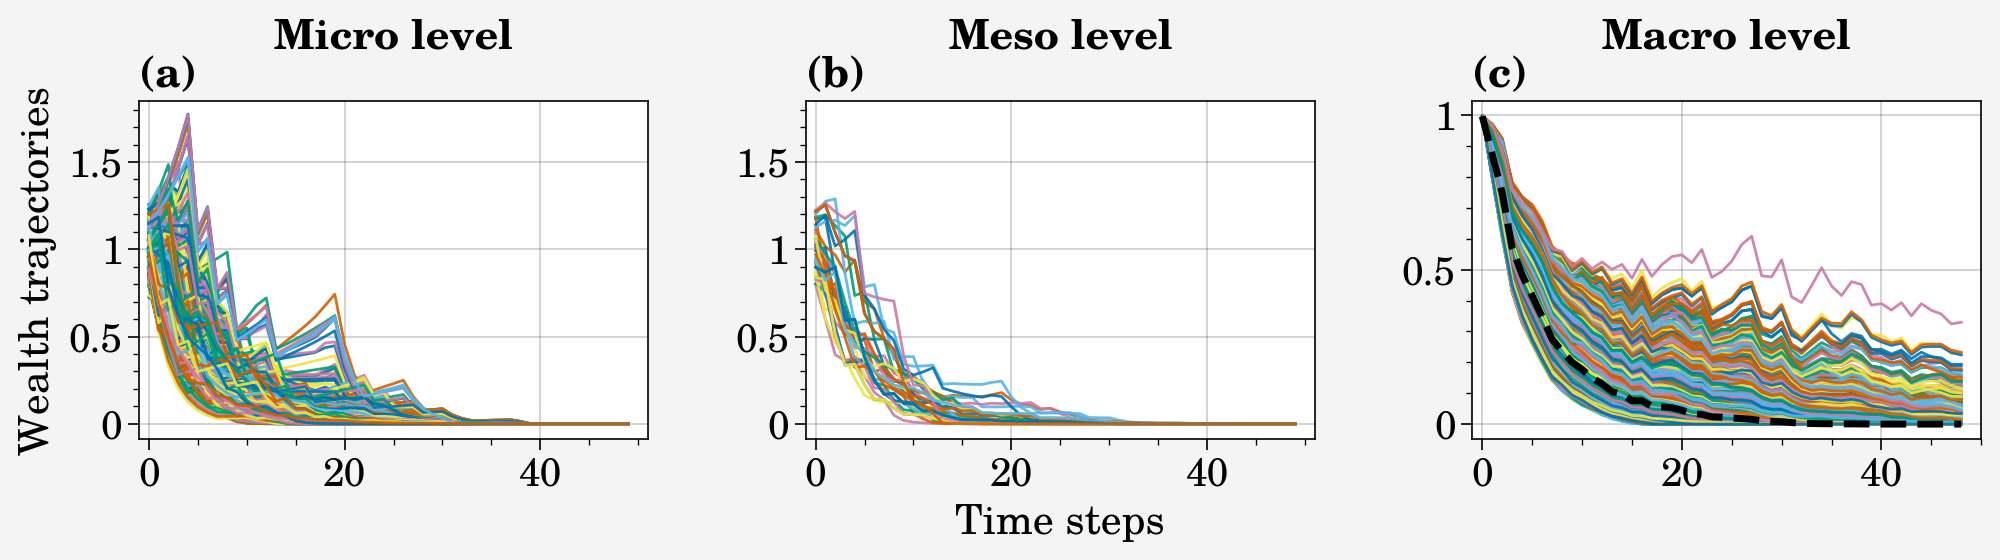

In [17]:
pplt.rc['tick.labelsize'] = 14

fig, axs = pplt.subplots(ncols=3, nrows=1, figsize=(10, 2.8), sharey=False, sharex=True)

# trajectories
for i in range(micro_data_original_shape.shape[2]):
    axs[0].plot(micro_data_original_shape[0][600][i][:], alpha=0.9, lw=1)
    axs[0].set_xlim(-1, 51)
    axs[0].set_ylim(-0.09, 1.85)

for i in range(meso_data_original_shape.shape[2]):
    axs[1].plot(meso_data_original_shape[0][600][i][:], alpha=0.9, lw=1)
    axs[1].set_xlim(-1, 51)
    axs[1].set_ylim(-0.09, 1.85)

for i in np.concatenate((np.arange(0, 600, 1), np.arange(601, 256*5, 1)), axis=None):
    axs[2].plot(macro_data_original_shape[0][i], alpha=0.9, lw=1)
    axs[2].set_xlim(-1, 50)

axs[2].plot(macro_data_original_shape[0][600], 
            color='black', 
            linestyle='--',
            alpha=1, lw=2.5)

axs.set_xlabel("Time steps")

axs[0].set_ylabel(r"Wealth trajectories", fontsize=18)
axs[1].set_ylabel(" ")
axs[2].set_ylabel(" ")
    
for i, ax in enumerate(axs):
    ax.format(title=numbering[i], titleloc='left', 
              titlepad=5, titleweight='bold')
axs.format(toplabels=["Micro level", "Meso level", "Macro level"])

axs.format(rc_kw={'label.size': 15,
                  'tick.labelsize': 14,
                  'title.size': 15,
                  'toplabel.pad': 0.1,
                  'toplabel.color': "k"})

plt.tight_layout()
plt.savefig('plots/PT/PT3_all_traj_10runs.pdf',  dpi=300, bbox_inches='tight')
plt.show()

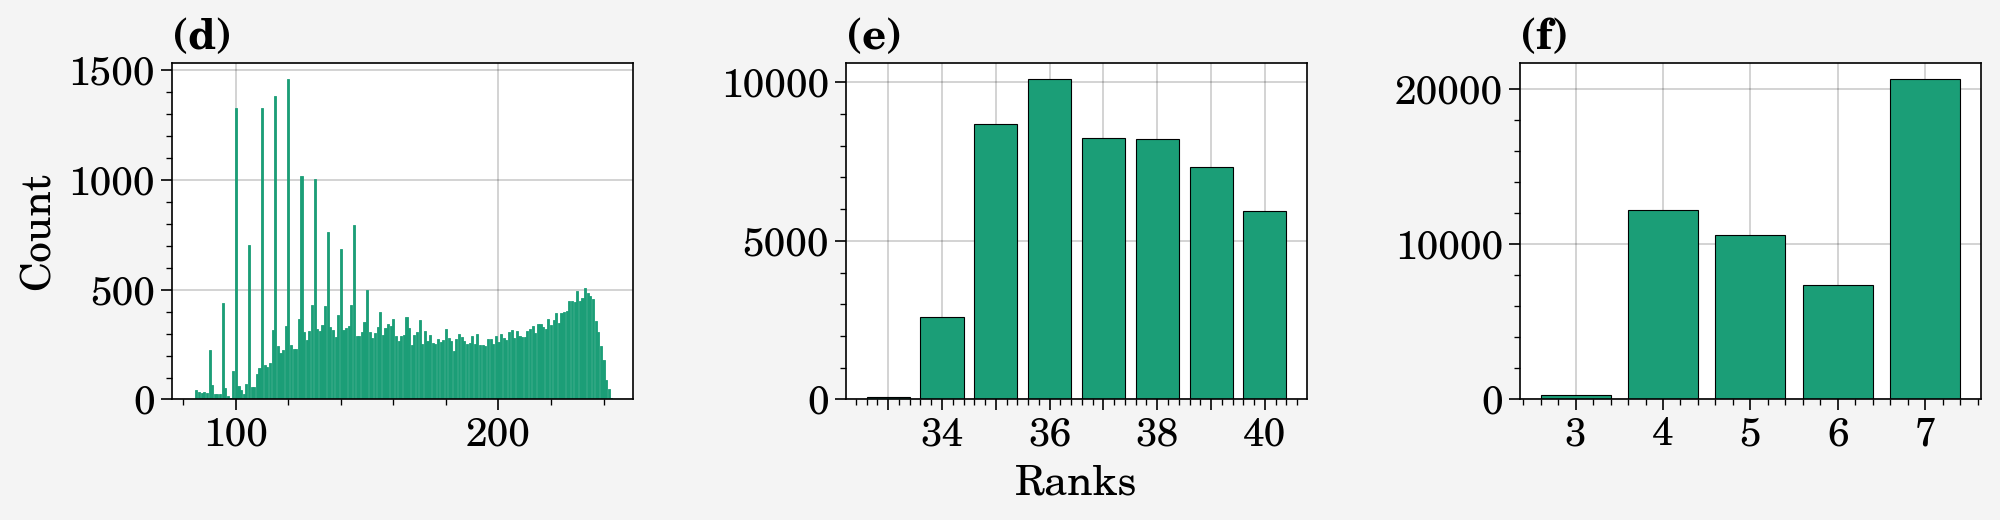

In [18]:
fig, axs = pplt.subplots(ncols=3, nrows=1, figsize=(10, 2.6), sharey=False, sharex=True)

# histograms
axs[0].bar(unique_micro, counts_micro, facecolor = '#1b9e77')

axs[1].bar(unique_meso, counts_meso, facecolor = '#1b9e77', edgecolor='k', linewidth=0.4)
xticks_label_meso = ['{}'.format(num) if num % 2 == 0 else ' ' for num in unique_meso]
axs[1].set_xticks(unique_meso, xticks_label_meso)

axs[2].bar(unique_macro, counts_macro, facecolor = '#1b9e77', edgecolor='k', linewidth=0.4)
xticks_label_macro = ['{}'.format(num) for num in unique_macro]
axs[2].set_xticks(unique_macro, xticks_label_macro)

for ax in axs:
    ax.set_xlabel(r"Ranks")
    
axs[0].set_ylabel("Count")
axs[1].set_ylabel(" ")
axs[2].set_ylabel(" ")
    
for i, ax in enumerate(axs):
    ax.format(title=numbering[i+3], titleloc='left', 
              titlepad=5, titleweight='bold')
    
axs.format(rc_kw={'label.size': 15,
                  'title.size': 15,
                  'tick.labelsize': 14,
                  'title.size': 15})
    
plt.tight_layout()
plt.savefig('plots/PT/PT3_hist_10runs.pdf', bbox_inches='tight')
plt.show()

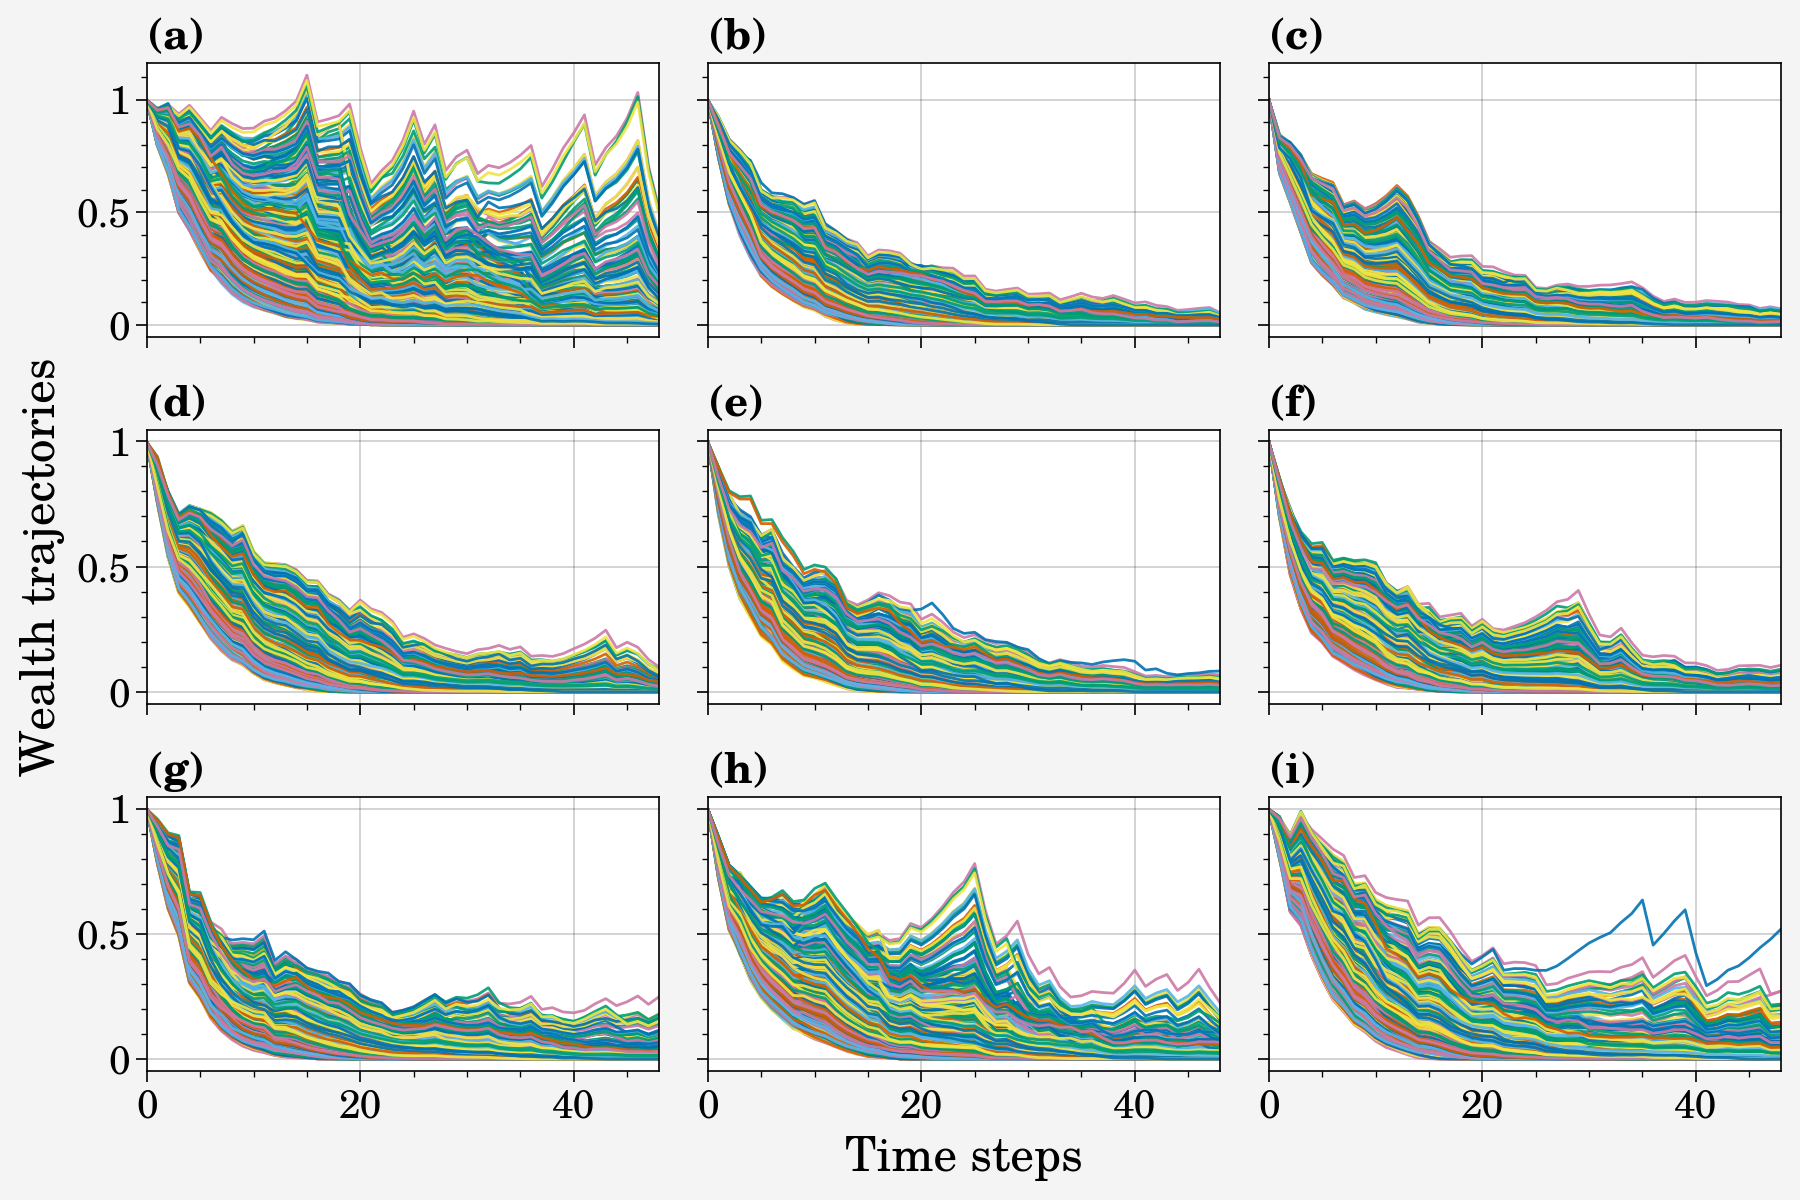

In [30]:
pplt.rc['tick.labelsize'] = 14

fig, axs = pplt.subplots(ncols=3, nrows=3, figsize=(9, 6), sharey=True, sharex=True)


for pl, j in enumerate(np.arange(1, 10, 1)):
    for i in range(128*5):
        axs[pl].plot(macro_data_original_shape[j][i], alpha=0.9, lw=1)

axs.set_xlabel("Time steps")
axs.set_ylabel(r"Wealth trajectories")

axs.format(abc='(a)',
           rc_kw={'label.size': 17,
                  'tick.labelsize': 14,
                  'abc.size':  15,
                  'title.size': 15,
                  'toplabel.pad': 0.1,
                  'toplabel.color': "k"})

plt.tight_layout()
plt.savefig('plots/PT/PT3_all_traj_10runs_allmacro.pdf',  dpi=300, bbox_inches='tight')
plt.show()

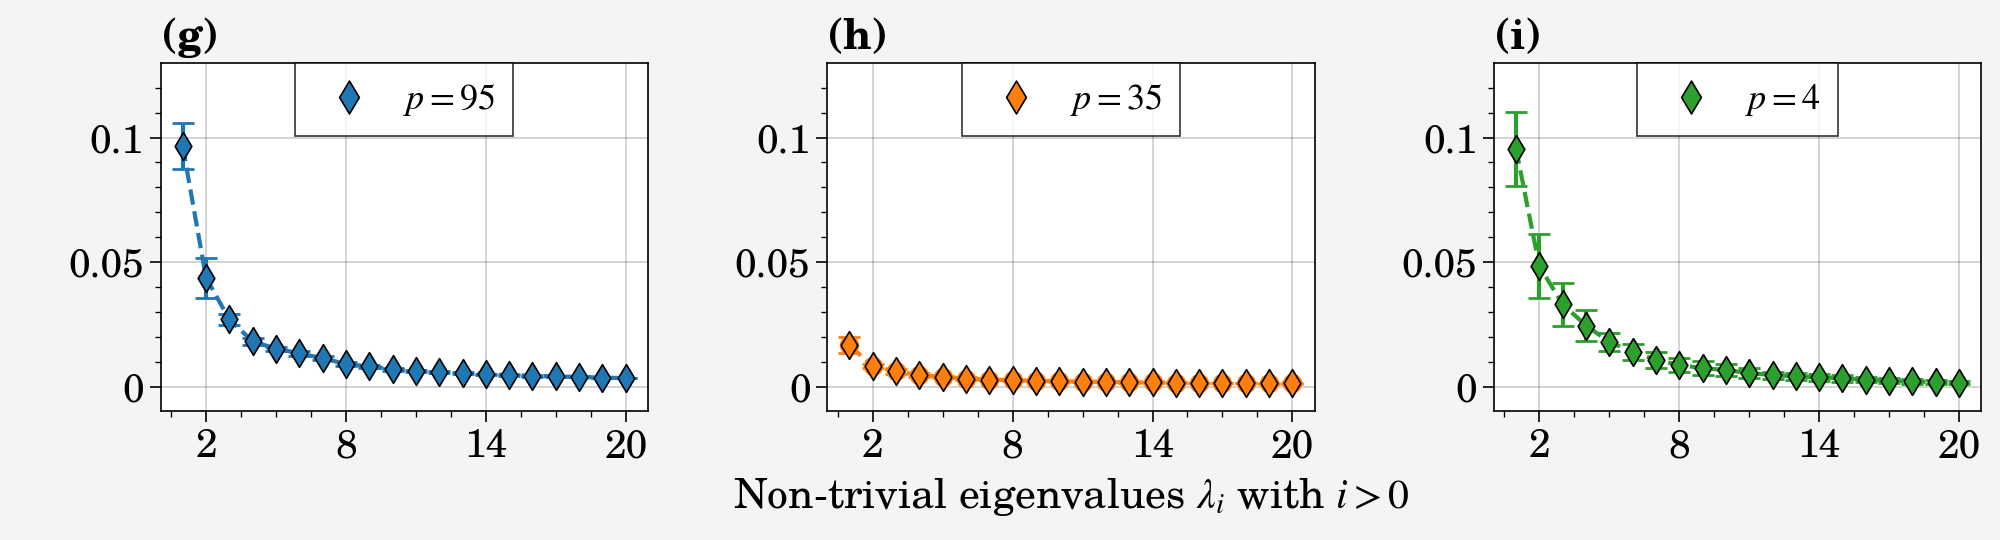

In [24]:
colors=mcp.gen_color(cmap="tab10",n=10)

ticks_x = np.linspace(2, 20, 4, dtype='int')

fig, axs = pplt.subplots(ncols=3, nrows=1, figsize=(10, 2.7), sharey=False, sharex=True)

# screeplots
x = np.arange(1, len(evals_micro_p_95[0]), 1)
axs[0].scatter(x, np.mean(evals_micro_p_95, axis=0)[1:],
               color=colors[0], label=r"$p=95$", 
               edgecolor="k", marker="d", 
               markersize=50, zorder=3)
axs[0].errorbar(x, np.mean(evals_micro_p_95, axis=0)[1:], 
                np.std(evals_micro_p_95, axis=0, ddof=1)[1:],
                color=colors[0],
                linestyle='--', capsize=4)

    
axs[1].scatter(x, np.mean(evals_meso_p_35, axis=0)[1:],
               color=colors[1], label=r"$p=35$", 
               edgecolor='k', marker="d", 
               markersize=50, zorder=3)
axs[1].errorbar(x,
                np.mean(evals_meso_p_35, axis=0)[1:], 
                np.std(evals_meso_p_35, axis=0, ddof=1)[1:],
                color=colors[1],
                linestyle='--', marker='o', capsize=4)
    
axs[2].scatter(x, np.mean(evals_macro_p_4, axis=0)[1:],
               color=colors[2], label=r"$p=4$", 
               edgecolor="k", marker="d", 
               markersize=50, zorder=3)
axs[2].errorbar(x, np.mean(evals_macro_p_4, axis=0)[1:], 
                np.std(evals_macro_p_4, axis=0, ddof=1)[1:],
                color=colors[2],
                linestyle='--', capsize=4)

    
for i, ax in enumerate(axs):
    ax.set_xticks(ticks_x,
                  ['{}'.format(num) for num in ticks_x])
    ax.set_ylabel(" ")
    ax.set_ylim(-0.01, 0.13)
    lgnd = ax.legend(fontsize=13, loc='uc')
    ax.set_xlabel(r'Non-trivial eigenvalues $\lambda_i$ with $i > 0$')
    lgnd.legendHandles[0]._sizes = [70]
    
for i, ax in enumerate(axs):
    ax.format(title=numbering[i+6], titleloc='left', 
              titlepad=5, titleweight='bold')

axs.format(rc_kw={'label.size': 15,
                  'tick.labelsize': 14,
                  'title.size': 15})
        
plt.tight_layout()

plt.savefig('plots/PT/PT3_screeplots_10runs.pdf', bbox_inches='tight')
plt.show()

## Scatterplots: diffusion coordinates

In [20]:
coord_data = [coords_micro_p_95, coords_meso_p_35, coords_macro_p_4]
g_data_all_runs = [d_coords_micro_p_95, d_coords_meso_p_35, d_coords_macro_p_4]

In [21]:
d_coords_micro_p_95[0].shape

(5120, 3)

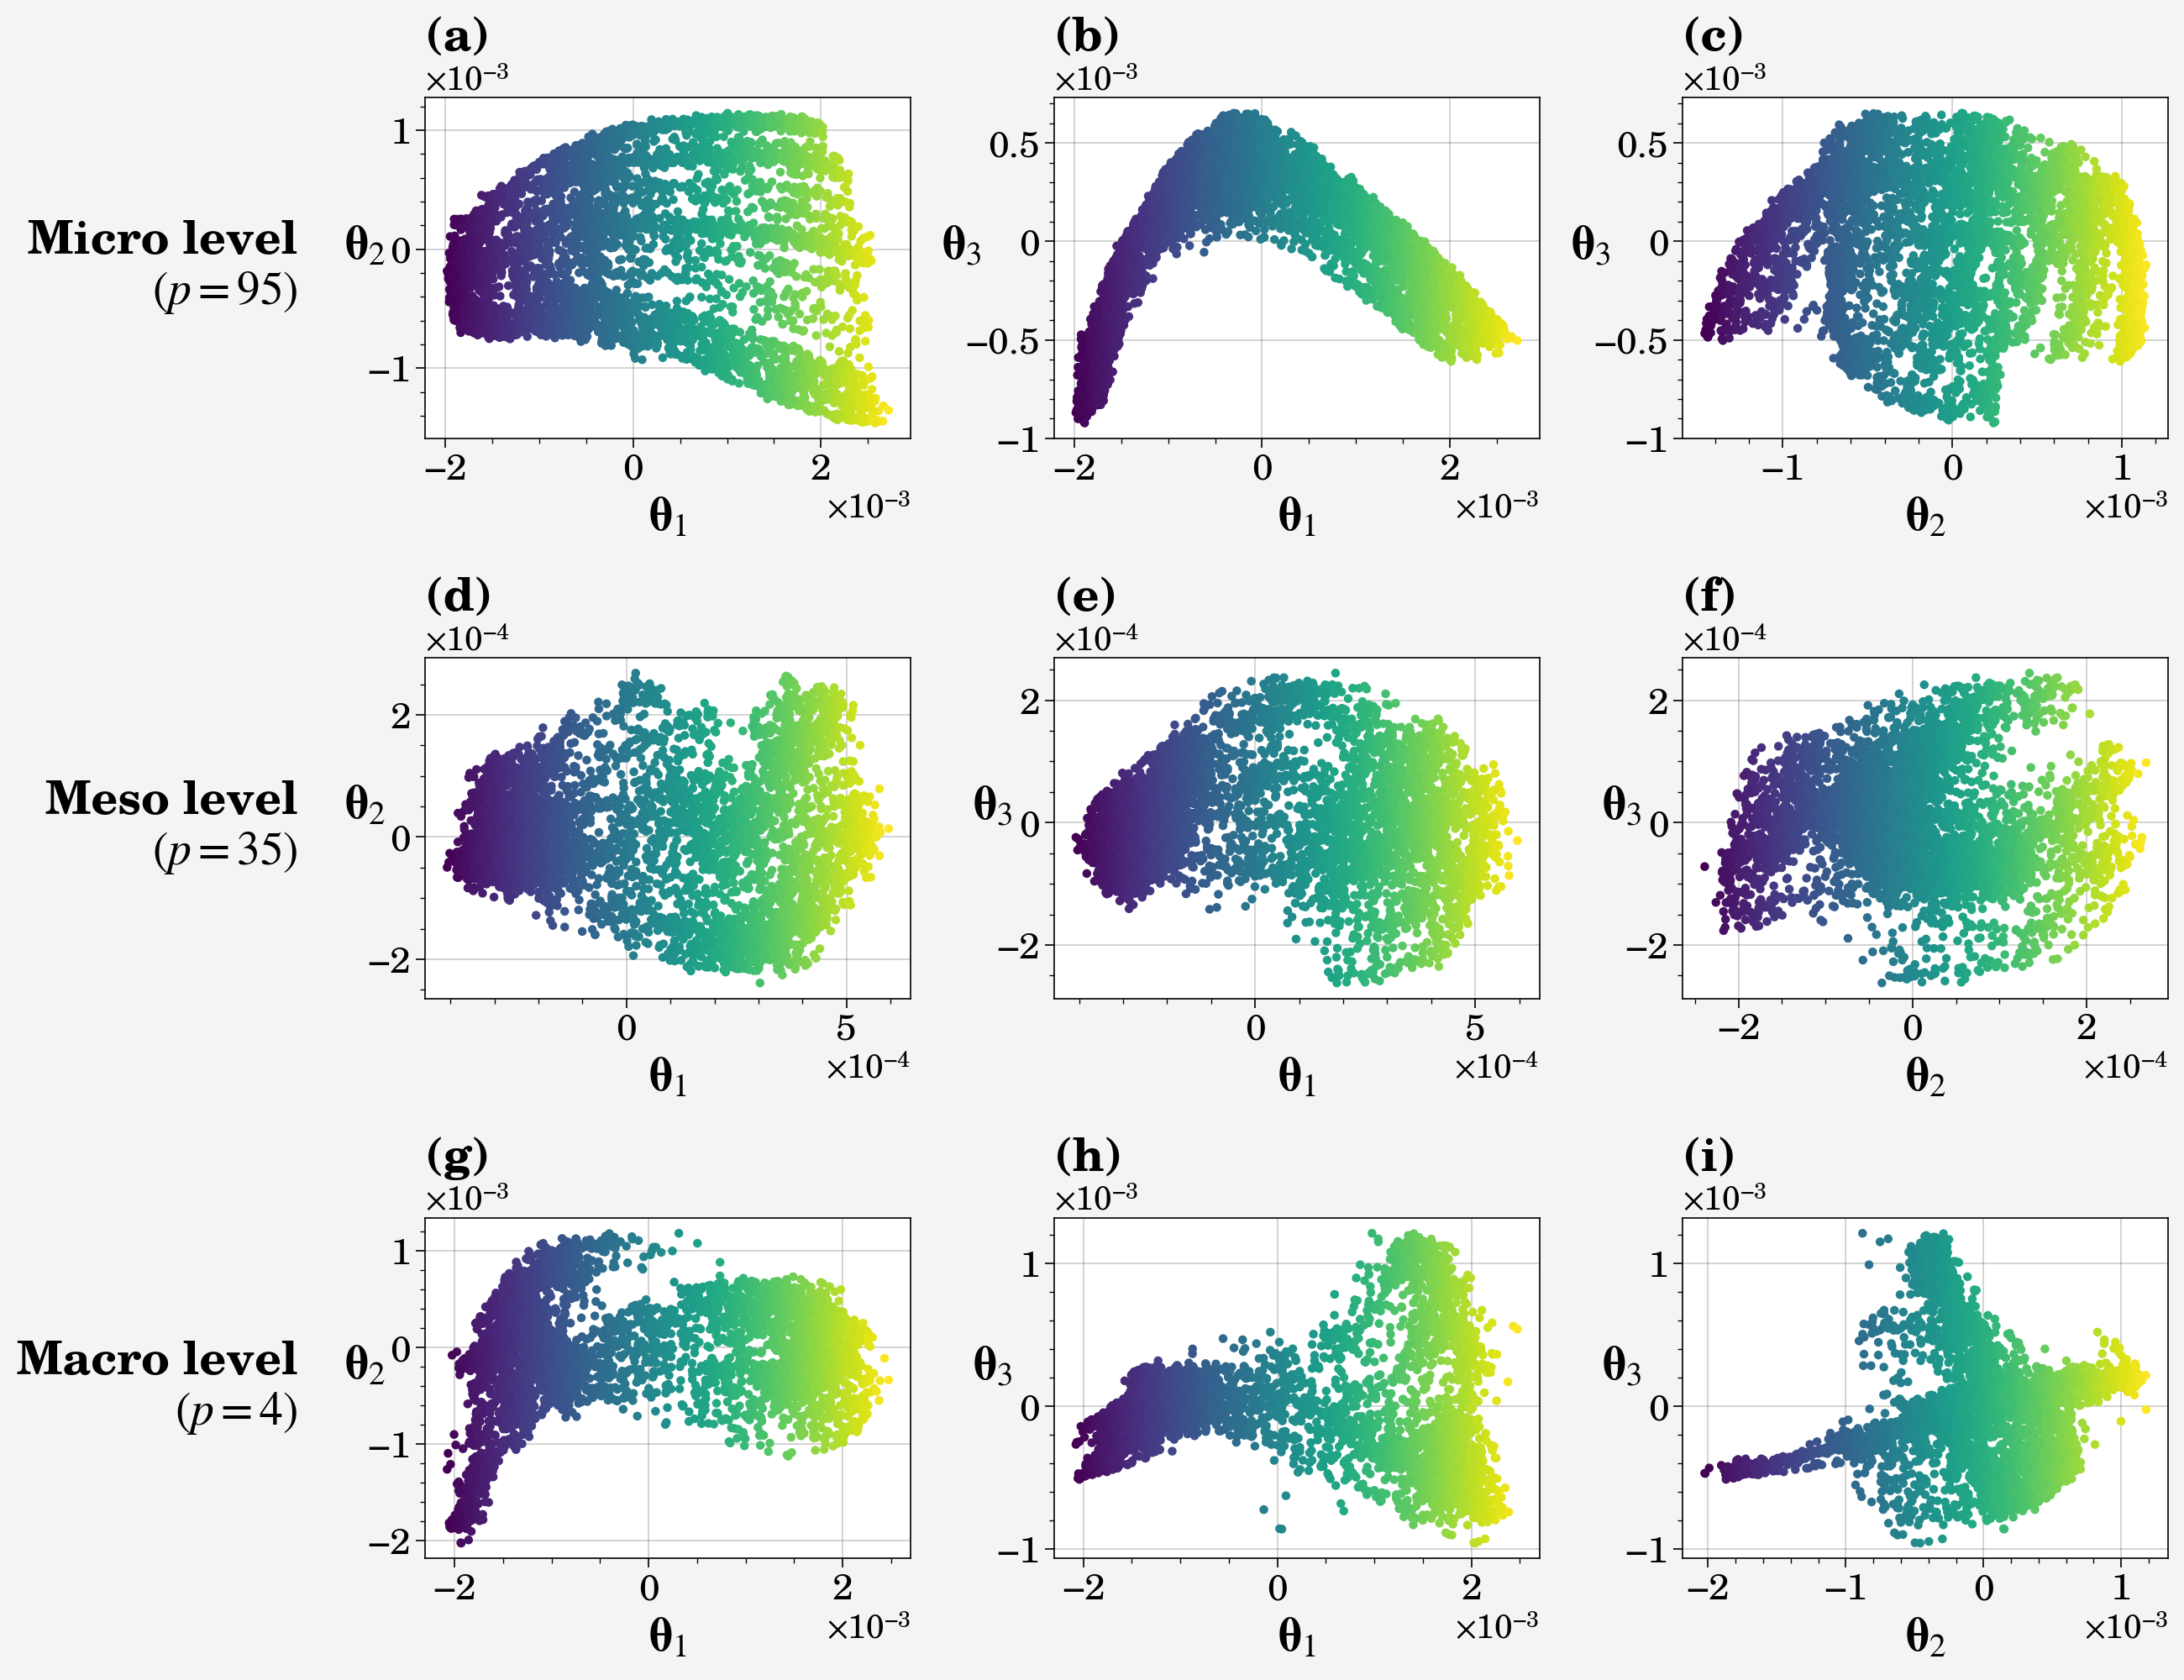

In [29]:
run = 0

fig, axs = pplt.subplots(ncols=3, nrows=3, figsize=(13, 10), sharex=False, sharey=False)

for row, g_data in enumerate(g_data_all_runs):
    axs[row*3].scatter(g_data[run][:, 0], g_data[run][:, 1], 
                       c=g_data[run][:, 0], cmap='viridis', 
                       s=10)
#     edgecolors='k', linewidth=0.1)

    axs[row*3].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][0]))
    axs[row*3].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][1]),
                           labelpad=10)
    
    axs[row*3+1].scatter(g_data[run][:, 0], g_data[run][:, 2], 
                         c=g_data[run][:, 0], cmap='viridis', 
                         s=10)
    
#     edgecolors='k', linewidth=0.1)
    axs[row*3+1].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][0]))
    axs[row*3+1].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][2]),
                           labelpad=10)

    axs[row*3+2].scatter(g_data[run][:, 1], g_data[run][:, 2], 
                         c=g_data[run][:, 1], cmap='viridis', 
                         s=10)
#     edgecolors='k', linewidth=0.1)
    axs[row*3+2].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][1]))
    axs[row*3+2].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][2]),
                           labelpad=10)
    
    for ax in axs:
        ax.ticklabel_format(style="scientific", scilimits=(-2, -3))
        ax.format(abc='(a)',
                  rc_kw={'title.size': 17,
                         'label.size': 20,
                         'tick.labelsize': 16,
                         'abc.size':  20,
                         'title.pad': 20,
                         'leftlabel.size': 20,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 20.0,
                         'leftlabel.color': "k"})
        

axs.format(leftlabels=["Micro level\n"+r"$(p=95)$",
                       "Meso level\n"+r"$(p=35)$", 
                       "Macro level\n"+r"$(p=4)$"])

for i, ax in enumerate(axs):
    ax.yaxis.label.set(rotation='horizontal', ha='left')
    

fig.tight_layout()
plt.savefig(f'plots/PT/PT3_nonparsim_dcoords_run{run}.pdf', dpi=300, bbox_inches='tight')
plt.show()       

## Sensitivity Indices

In [28]:
def plot_GSA_OLS_LAR(SIs, suptitle, figsize, legend_n_cols,toplabels, title, top=True):
    
    n_res = len(SIs)
    
    n_d_coord = 3
    
    s_max = np.linspace(2, 15, 14, dtype='int')
    
    param_names = [r"$COST$",r"$\beta$", r"$\ell$"]
    colors = [u'#1f77b4', u'#2ca02c', u'#d62728']
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    fig, axs = pplt.subplots(ncols=n_res, nrows=3, figsize=figsize, sharex=True, sharey=True)
    
    for d in range(n_d_coord):
        for i, param in enumerate(param_names):
            for j, si in enumerate(SIs):

                axs[d,j].scatter(s_max, si.mean(axis=0)[:, i, d], label=param,
                                 color=colors[i], edgecolor="k", marker=marker_styles[i], 
                                 markersize=80, linewidth=0.4, zorder=3)
                axs[d,j].errorbar(s_max, si.mean(axis=0)[:, i, d],
                                  si.var(axis=0, ddof=1)[:, i, d],
                                  markeredgewidth=1.4, color=colors[i],
                                  linestyle='--', capsize=7, alpha=1, elinewidth=1) 
     
   
    axs.format(toplabels=toplabels,
              suptitle=suptitle,
              leftlabels=[r"$\mathbf{\theta}_1$", 
                          r"$\mathbf{\theta}_2$",
                          r"$\mathbf{\theta}_3$"],)

    for i, ax in enumerate(axs):
        ax.format(abc='(a)')
        ax.set(ylim=(-0.06, 1.02))
        ax.format(rc_kw={'suptitle.size': 22,
                         'suptitle.pad': 5.0,
                         'suptitle.color': "k",
                         'title.size': 22,
                         'abc.size': 20,
                         'title.pad': 3.0,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 22,
                         'toplabel.pad': 1.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 14.0})
        
    ticks = np.linspace(1, 15, 8, dtype='int')
    axs.set_xticks(ticks,
                  ['{}'.format(num) for num in ticks])
    
    axs.set_xlabel(r'Maximum polynomial degree $s_{\mathrm{max}}$', fontsize=22, labelpad=5)
    
    if top:
        lgnd = fig.legend(param_names, ncols=legend_n_cols, frame=False, loc='t',
                       fontsize = 22, bbox_to_anchor=(0.5, 5))
        for i in range(len(param_names)):
            lgnd.legendHandles[i]._sizes = [100]
            
    for i, ax in enumerate(axs):
        ax.yaxis.label.set(rotation='horizontal', ha='right')

    fig.tight_layout()
    plt.savefig(f'plots/PT/' + title, bbox_inches='tight')
    plt.show()

In [29]:
GSA_micro_p_95 = np.load(PATH_PT3 + f"PCE_GSA/smax_2_15_nonparsim_3_param_micro_95.npz", 
                            allow_pickle=True)


LAR_fo_si_micro_p_95 = GSA_micro_p_95['x9']
LAR_to_si_micro_p_95 = GSA_micro_p_95['x10']

OLS_fo_si_micro_p_95 = GSA_micro_p_95['x1']
OLS_to_si_micro_p_95 = GSA_micro_p_95['x2']


GSA_meso_p_35 = np.load(PATH_PT3 + f"PCE_GSA/smax_2_15_nonparsim_3_param_meso_35.npz", 
                            allow_pickle=True)

LAR_fo_si_meso_p_35 = GSA_meso_p_35['x9']
LAR_to_si_meso_p_35 = GSA_meso_p_35['x10']

OLS_fo_si_meso_p_35 = GSA_meso_p_35['x1']
OLS_to_si_meso_p_35 = GSA_meso_p_35['x2']


GSA_macro_p_4 = np.load(PATH_PT3 + f"PCE_GSA/smax_2_15_nonparsim_3_param_macro_4.npz", 
                            allow_pickle=True)

GSA_macro_p_4 = np.load(PATH_PT3 + f"PCE_GSA/smax_2_15_nonparsim_3_param_macro_4.npz", 
                            allow_pickle=True)

LAR_fo_si_macro_p_4 = GSA_macro_p_4['x9']
LAR_to_si_macro_p_4 = GSA_macro_p_4['x10']

OLS_fo_si_macro_p_4 = GSA_macro_p_4['x1']
OLS_to_si_macro_p_4 = GSA_macro_p_4['x2']

In [30]:
def plot_LAR_SIs_all_levels(SIs, figsize, subplot_titles, legend_space, title, suptitle=None):
    
    param_names = [r"$COST$",r"$\beta$", r"$\ell$"]
    theta_labels = [r"First $\theta$", r"Second $\theta$", r"Third $\theta$"]
    colors = [u'#1f77b4', u'#2ca02c', u'#d62728']
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    n_rows = int(len(SIs)/2)

    fig, axs = pplt.subplots(ncols=2, nrows=n_rows, figsize=figsize, sharex=True, sharey=True)
    

    for j, si in enumerate(SIs):
        for i, param in enumerate(param_names):

            axs[j].scatter([1,2,3], np.mean(si,axis=0)[i], label=param,
                             color=colors[i], edgecolor="k", marker=marker_styles[i], 
                             markersize=80, linewidth=0.4, zorder=3)
            axs[j].errorbar([1,2,3], np.mean(si,axis=0)[i],
                                  si.var(axis=0, ddof=1)[i],
                                  markeredgewidth=1.4, color=colors[i],
                                  linestyle='--', capsize=7, alpha=1, elinewidth=1) 
            axs[j].set_title(subplot_titles[j])
            
    for ax in axs:
        ax.set_xlim(0.9, 3.1)
        ax.set_ylim(-0.05, 1.05)
      
    ticks = [1,2,3]
    axs.set_xticks(ticks, [r"$\mathbf{\theta}_1$", 
                           r"$\mathbf{\theta}_2$",
                           r"$\mathbf{\theta}_3$"])
    
    for i, ax in enumerate(axs):
        ax.format(abc='(a)',
                 suptitle=suptitle)
        ax.format(rc_kw={'suptitle.size': 20,
                         'suptitle.pad': 8.0,
                         'title.size': 20,
                         'title.pad': 10,
                         'abc.bboxpad': 10.0,
                         'abc.size': 20,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 20,
                         'toplabel.pad': 5.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 14.0})
        
    lgnd = fig.legend(param_names, ncols=4, frame=False, loc='t',
                       fontsize = 20, bbox_to_anchor=(0.5, legend_space))
    for i in range(len(param_names)):
        lgnd.legendHandles[i]._sizes = [100]
    
    fig.tight_layout()
    plt.savefig(f'plots/PT/' + title, bbox_inches='tight')
    plt.show()  

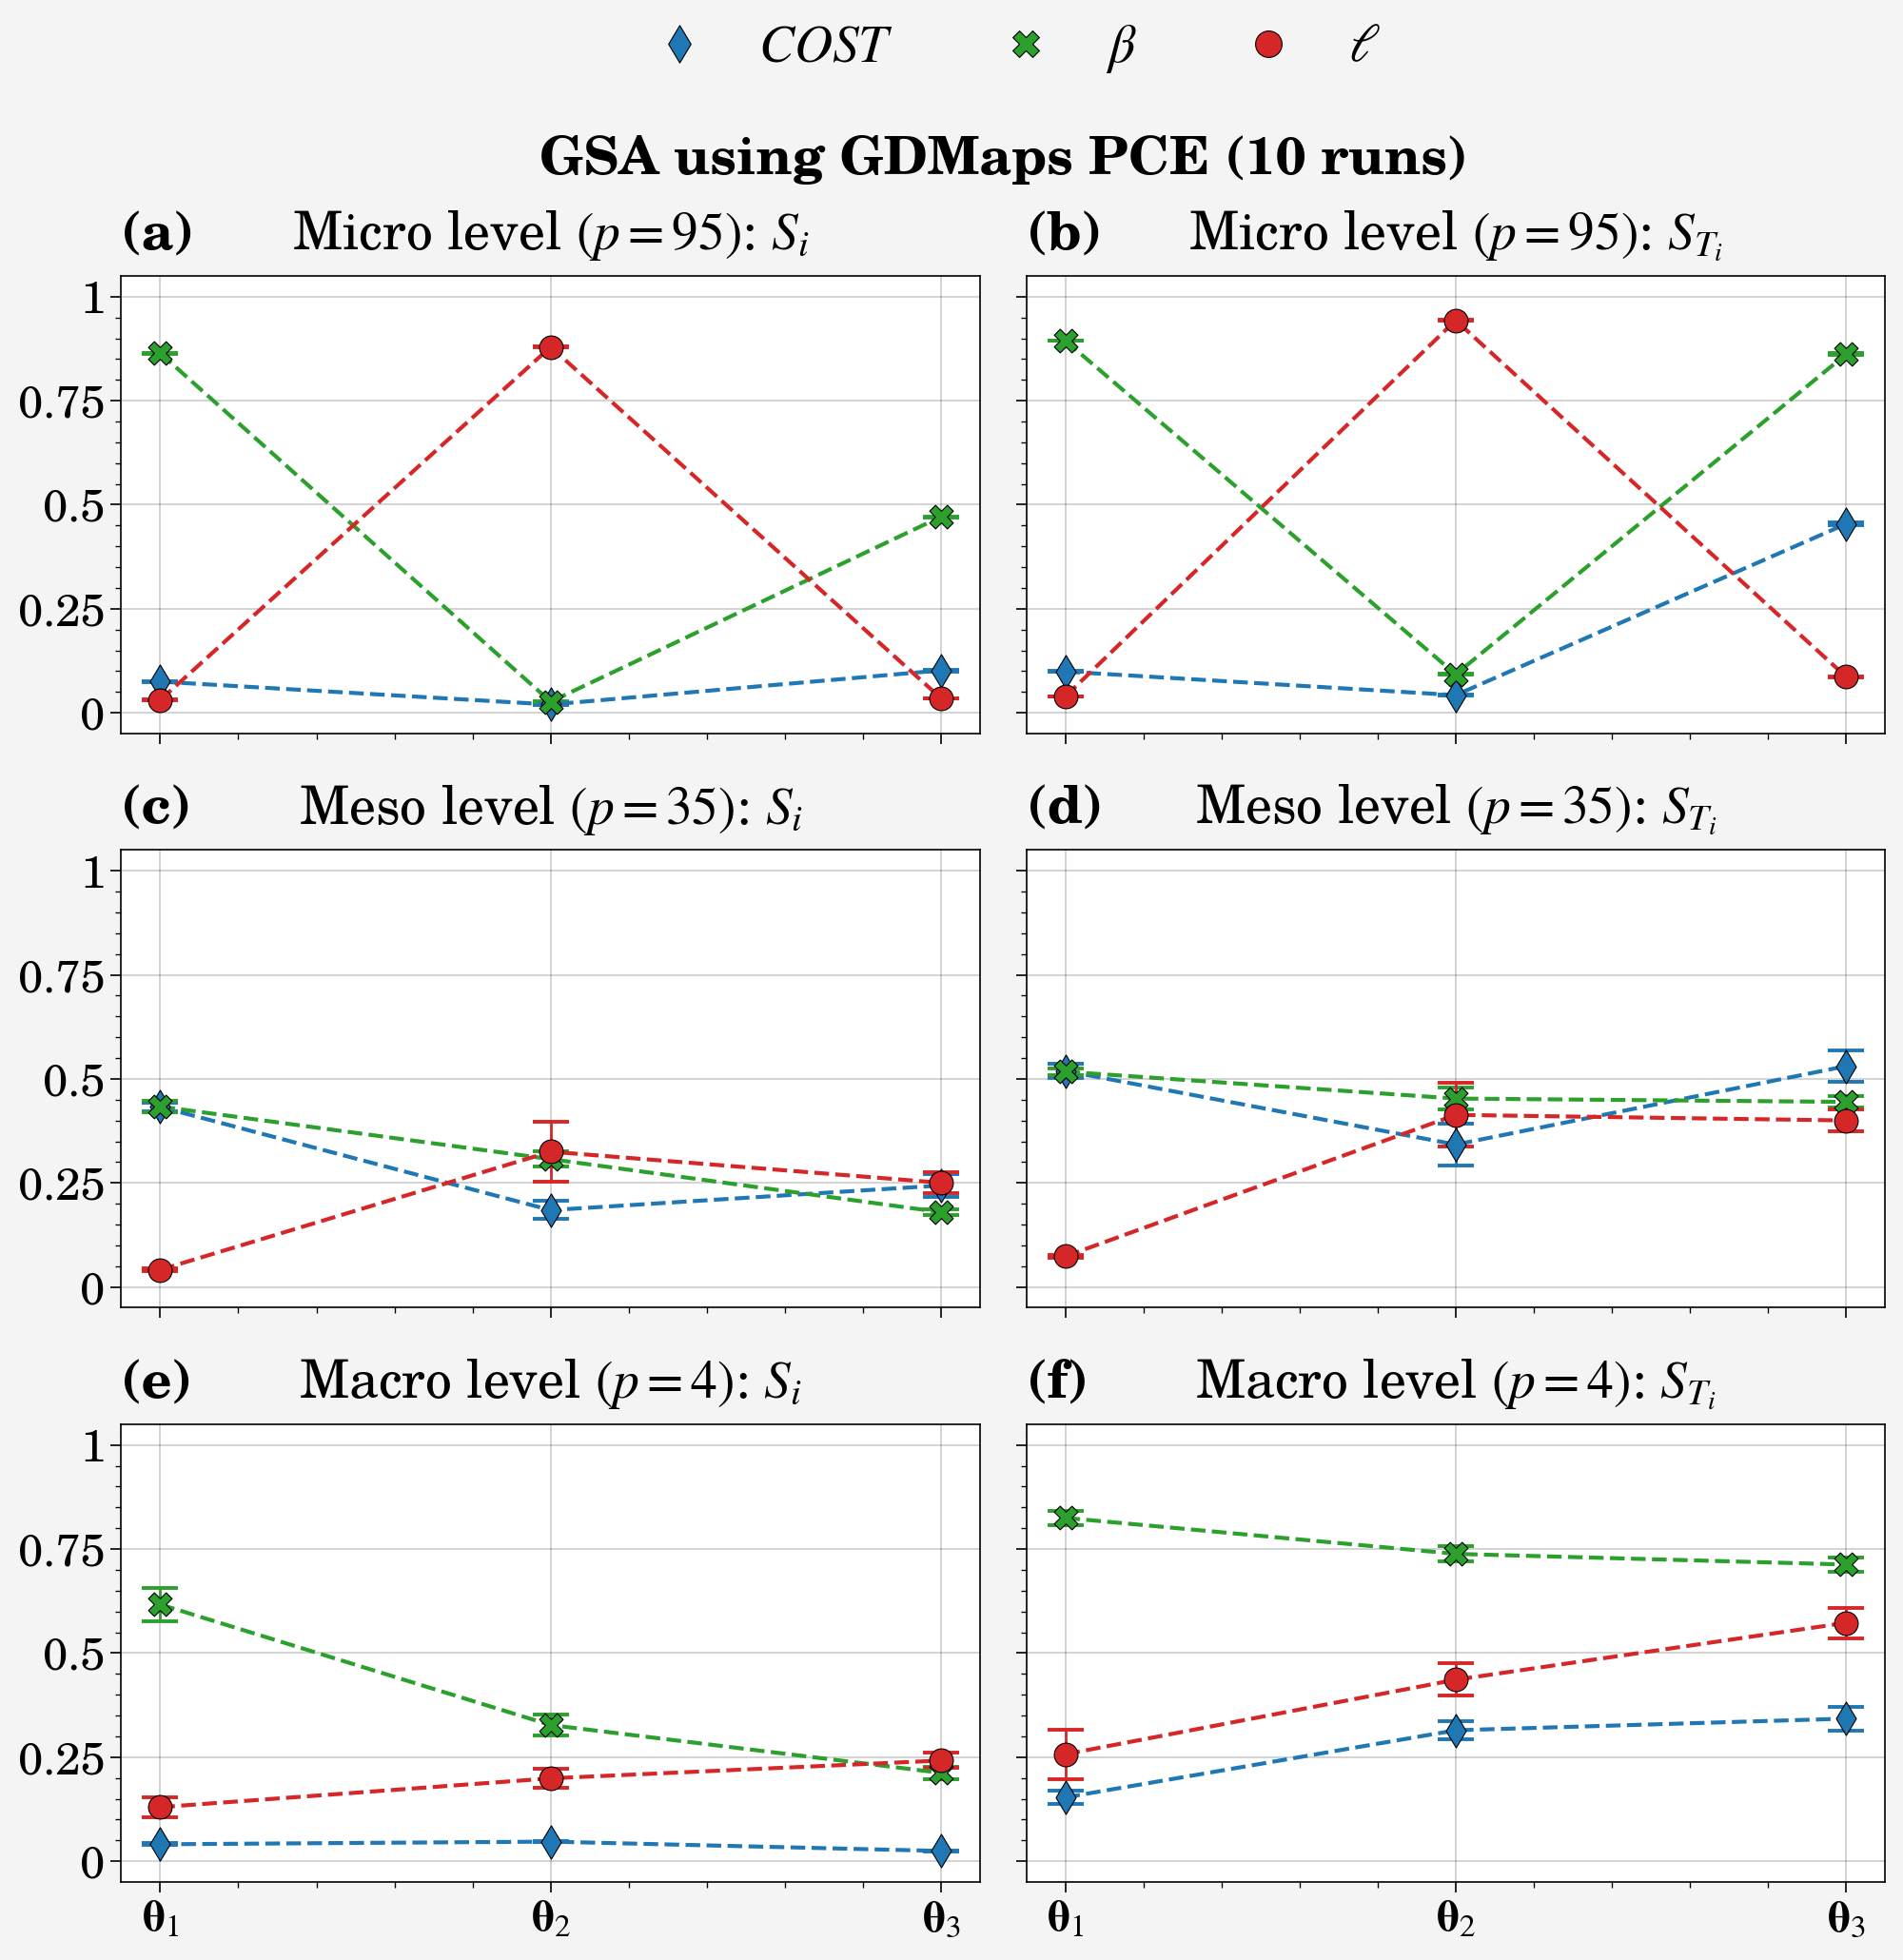

In [31]:
plot_LAR_SIs_all_levels(SIs = [LAR_fo_si_micro_p_95[:, -1, :, :], 
                               LAR_to_si_micro_p_95[:, -1, :, :],
                               LAR_fo_si_meso_p_35[:, -1, :, :], 
                               LAR_to_si_meso_p_35[:, -1, :, :],
                               LAR_fo_si_macro_p_4[:, -1, :, :],
                               LAR_to_si_macro_p_4[:, -1, :, :]],
                         subplot_titles = [r'Micro level $({p=95})$: $S_{i}$',
                                           r'Micro level $({p=95})$: $S_{T_i}$',
                                           r'Meso level $({p=35})$: $S_{i}$',
                                           r'Meso level $({p=35})$: $S_{T_i}$',
                                           r'Macro level $({p=4})$: $S_{i}$',
                                           r'Macro level $({p=4})$: $S_{T_i}$'],
                         suptitle = "GSA using GDMaps PCE (10 runs)",
                         legend_space=2.5,
                         figsize=(10,  10.3),
                         title = "PT3_GSA_10_runs.pdf")

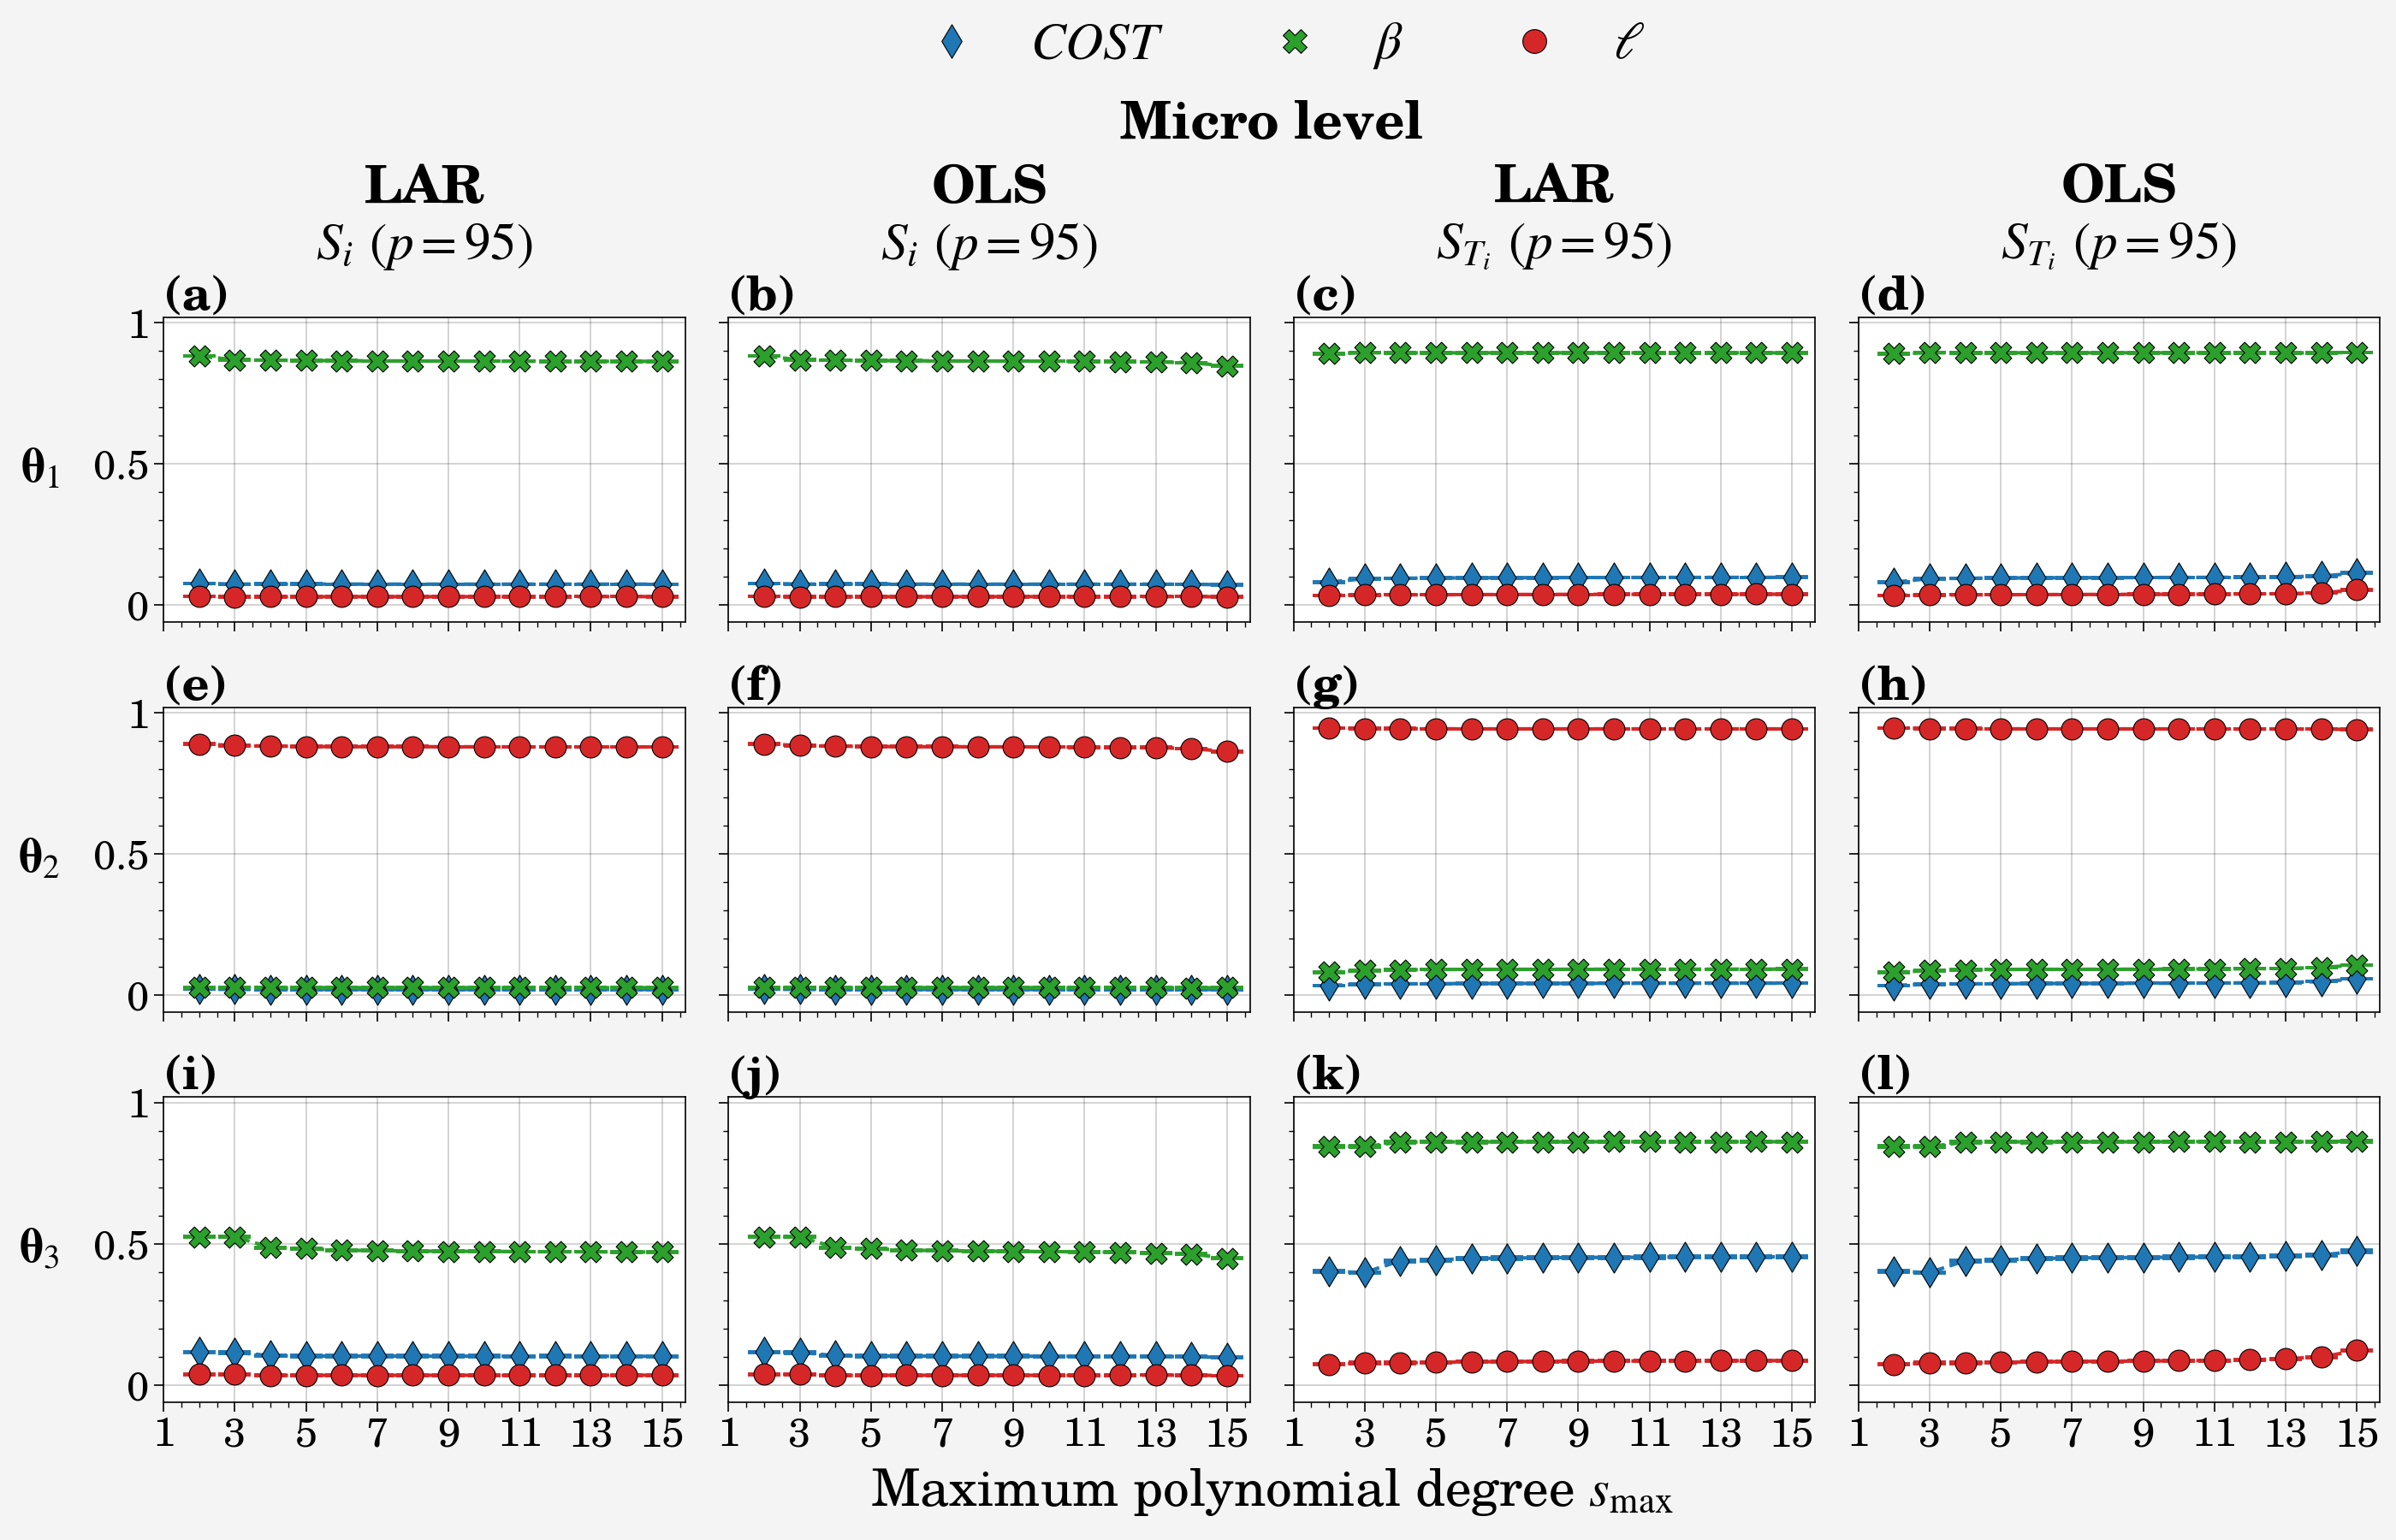

In [32]:
# numbering = ["(y)", "(z)"] + ["(" + i+i + ")" for i in list(string.ascii_lowercase)]

plot_GSA_OLS_LAR(SIs = [LAR_fo_si_micro_p_95, OLS_fo_si_micro_p_95,
                        LAR_to_si_micro_p_95, OLS_to_si_micro_p_95],
                 figsize = (14, 9),
                 suptitle = "Micro level",
                 legend_n_cols  = 3,
                 toplabels = ('LAR\n'+r'$S_{i}$ $({p=95})$','OLS\n'+r'$S_{i}$ $({p=95})$',
                              'LAR\n'+r'$S_{T_i}$ $({p=95})$','OLS\n'+r'$S_{T_i}$ $({p=95})$'),
                 title = "PT3_micro_GSA.pdf")

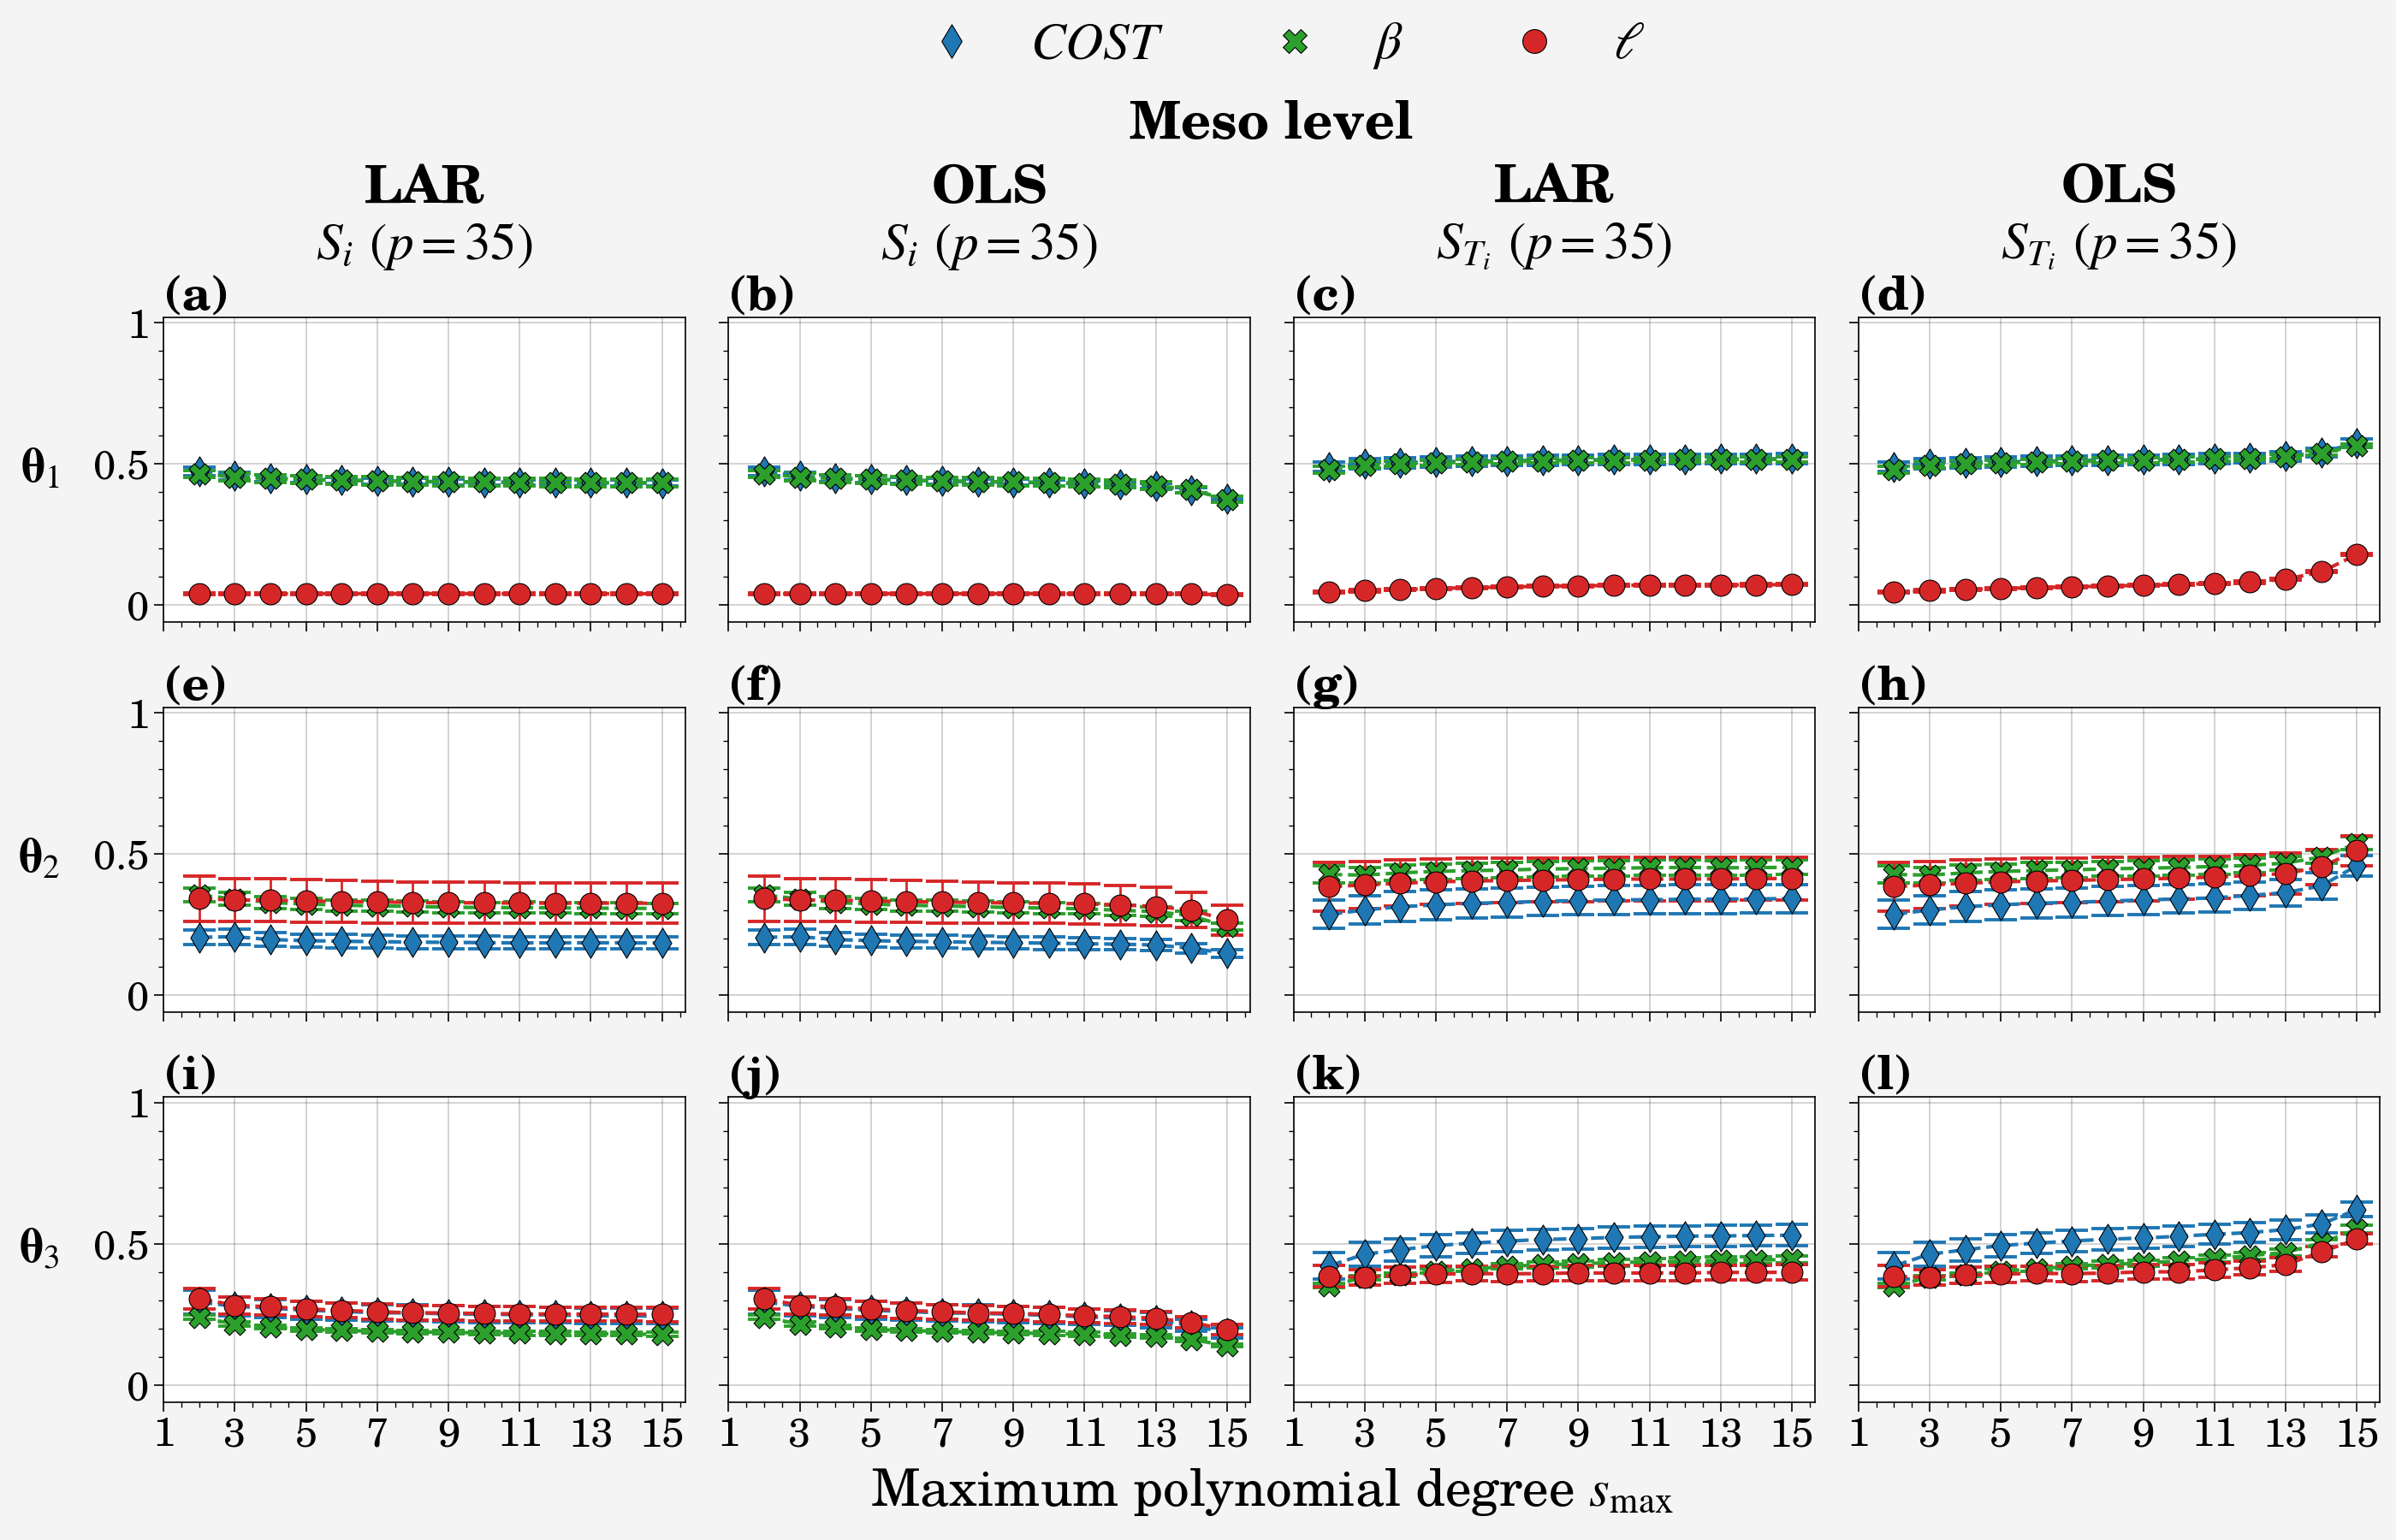

In [33]:
plot_GSA_OLS_LAR(SIs = [LAR_fo_si_meso_p_35, OLS_fo_si_meso_p_35,
                        LAR_to_si_meso_p_35, OLS_to_si_meso_p_35],
                 figsize = (14, 9),
                 suptitle = "Meso level",
                 legend_n_cols  = 3,
                 toplabels = ('LAR\n'+r'$S_{i}$ $({p=35})$','OLS\n'+r'$S_{i}$ $({p=35})$',
                              'LAR\n'+r'$S_{T_i}$ $({p=35})$','OLS\n'+r'$S_{T_i}$ $({p=35})$'),
                 title = "PT3_meso_GSA.pdf")

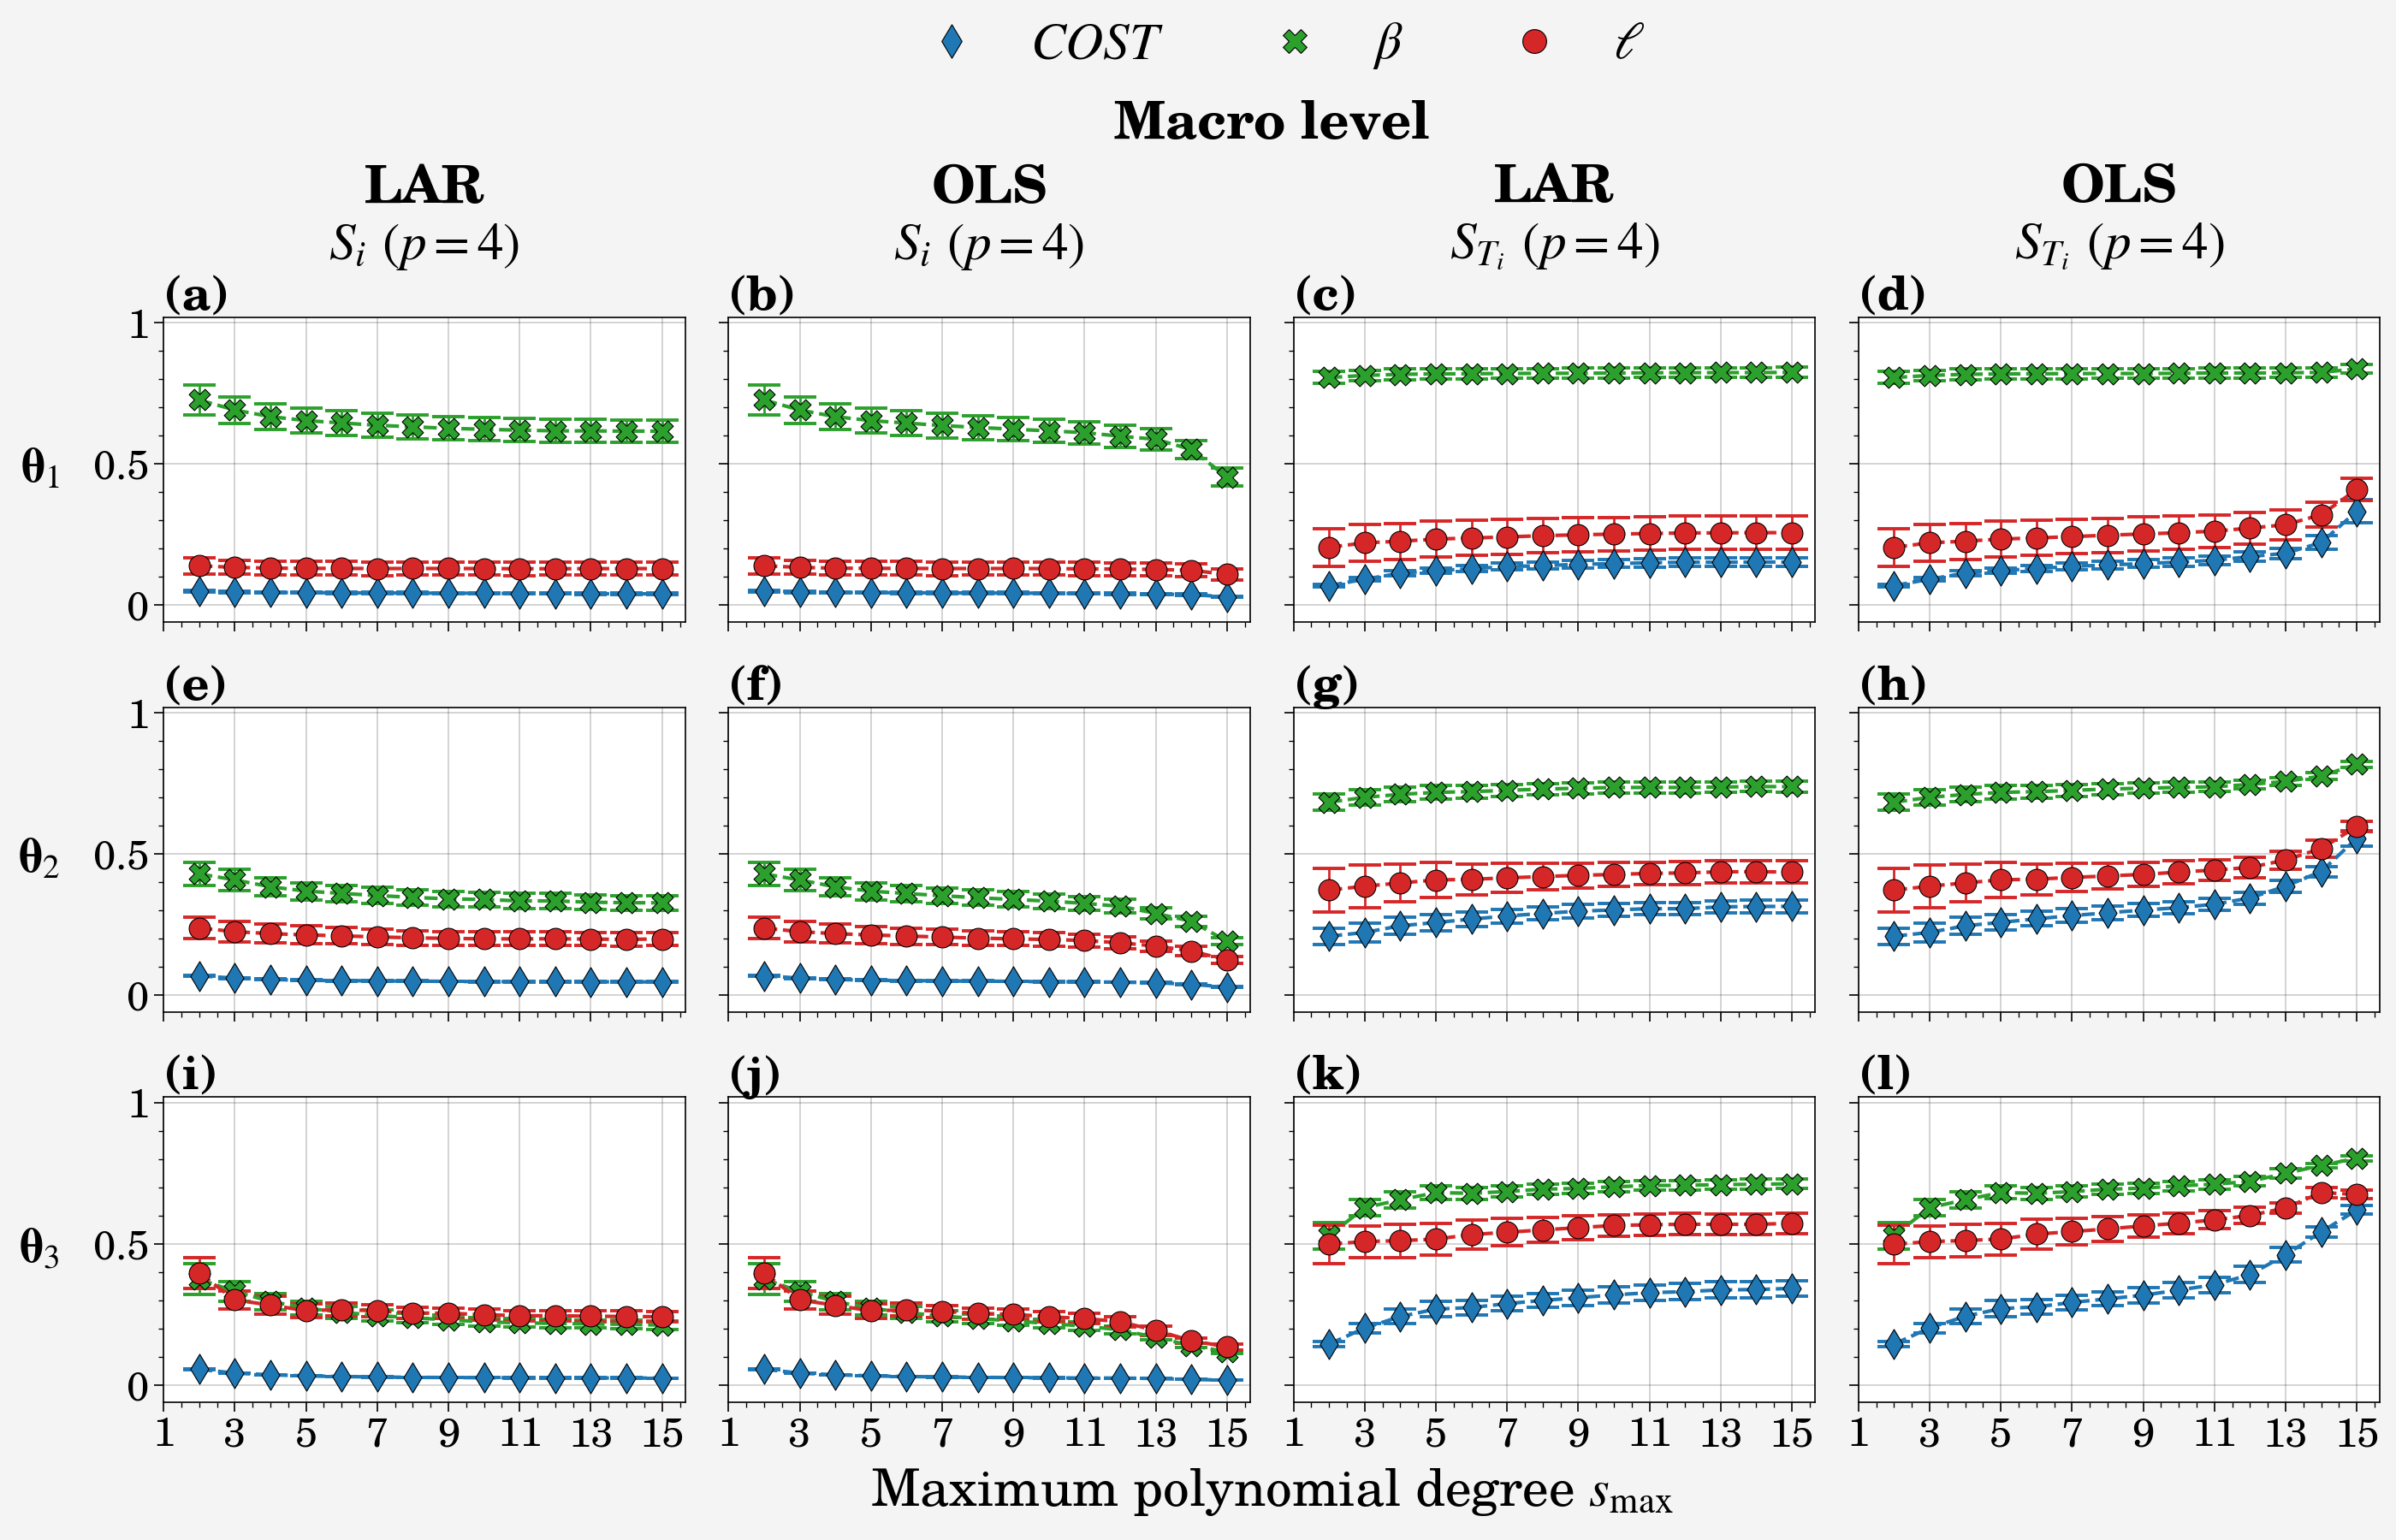

In [34]:
plot_GSA_OLS_LAR(SIs = [LAR_fo_si_macro_p_4, OLS_fo_si_macro_p_4,
                        LAR_to_si_macro_p_4, OLS_to_si_macro_p_4],
                 figsize = (14, 9),
                 suptitle = "Macro level",
                 legend_n_cols  = 3,
                 toplabels = ('LAR\n'+r'$S_{i}$ $({p=4})$','OLS\n'+r'$S_{i}$ $({p=4})$',
                              'LAR\n'+r'$S_{T_i}$ $({p=4})$','OLS\n'+r'$S_{T_i}$ $({p=4})$'),
                 title = "PT3_macro_GSA.pdf")

In [35]:
def plot_GSA_errors(errors, n_plot_cols, suptitle, figsize, legend_n_cols, 
                    toplabels, leftlabels, title, top=True):
    
    dcoords = [r"$\mathbf{\theta}_1$", r"$\mathbf{\theta}_2$", r"$\mathbf{\theta}_3$"]
    
    s_max = np.linspace(2, 15, 14, dtype='int')

    colors=mcp.gen_color(cmap="Dark2",n=7)
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    fig, axs = pplt.subplots(ncols=n_plot_cols, nrows=3, figsize=figsize, sharex=True, sharey=False)
    
    for j, error in enumerate(errors):
        for i, d in enumerate(dcoords):
            
            axs[j].scatter(s_max, error.mean(axis=0)[:,i], label=dcoords[i],
                             color=colors[i], edgecolor="k", marker=marker_styles[i], 
                             markersize=100, linewidth=0.4, zorder=3)
            axs[j].errorbar(s_max, error.mean(axis=0)[:,i],
                              error.var(axis=0, ddof=1)[:,i],
                              markeredgewidth=1.4, color=colors[i],
                              linestyle='--', capsize=7, alpha=1, elinewidth=1) 
   
    axs.format(toplabels=toplabels,
               suptitle=suptitle,
               leftlabels=leftlabels,)

    for i, ax in enumerate(axs):
        ax.format(abc='(a)')
        ax.format(rc_kw={'suptitle.size': 22,
                         'suptitle.pad': 5.0,
                         'suptitle.color': "k",
                         'title.size': 22,
                         'abc.bboxpad': 10.0,
                         'abc.size': 20,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 22,
                         'toplabel.pad': 5.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 10.0})
    
    ticks = np.linspace(1, 15, 8, dtype='int')
    axs.set_xticks(ticks,
                  ['{}'.format(num) for num in ticks])
    
    axs.set_xlabel(r'Maximum polynomial degree $s_{\mathrm{max}}$', fontsize=22, labelpad=5)
    
    if top:
        lgnd = fig.legend(dcoords, ncols=legend_n_cols, frame=False, loc='t',
                       fontsize = 22, bbox_to_anchor=(0.5, 2.5))
        
        for i in range(len(dcoords)):
            lgnd.legendHandles[i]._sizes = [100]
            
    for i, ax in enumerate(axs):
        ax.yaxis.label.set(rotation='horizontal', ha='right')

    fig.tight_layout()
    plt.savefig(f'plots/PT/' + title, bbox_inches='tight')
    plt.show()

In [36]:
def plot_MAE(errors, n_plot_cols, suptitle, figsize, legend_n_cols, toplabels, title, top=True):
    dcoords = [r"$\mathbf{\theta}_1$", r"$\mathbf{\theta}_2$", r"$\mathbf{\theta}_3$"]
    
    s_max = np.linspace(2, 15, 14, dtype='int')

    colors=mcp.gen_color(cmap="Dark2",n=7)
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    fig, axs = pplt.subplots(ncols=n_plot_cols, nrows=1, figsize=figsize, sharex=True, sharey=False)
    
    for j, error in enumerate(errors):
        for i, d in enumerate(dcoords):
            
            axs[j].scatter(s_max, error.mean(axis=0)[:,i], label=dcoords[i],
                             color=colors[i], edgecolor="k", marker=marker_styles[i], 
                             markersize=100, linewidth=0.4, zorder=3)
            axs[j].errorbar(s_max, error.mean(axis=0)[:,i],
                            error.var(axis=0, ddof=1)[:,i],
                            markeredgewidth=1.4, color=colors[i],
                            linestyle='--', capsize=7, alpha=1, elinewidth=1) 
            axs[j].set_title(r"$\mathrm{MAE}$")
   
    axs.format(toplabels=toplabels,
               suptitle=suptitle)

    for i, ax in enumerate(axs):
        ax.format(abc='(a)')
        ax.format(rc_kw={'suptitle.size': 22,
                         'suptitle.pad': 5.0,
                         'title.pad': 15.0,
                         'suptitle.color': "k",
                         'title.size': 22,
                         'abc.bboxpad': 15.0,
                         'abc.size': 20,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 22,
                         'toplabel.pad': 5.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 10.0})
    
    ticks = np.linspace(1, 15, 8, dtype='int')
    axs.set_xticks(ticks,
                  ['{}'.format(num) for num in ticks])
    
    axs.set_xlabel(r'Maximum polynomial degree $s_{\mathrm{max}}$', fontsize=22, labelpad=5)
    
    if top:
        lgnd = fig.legend(dcoords, ncols=legend_n_cols, frame=False, loc='t',
                       fontsize = 22, bbox_to_anchor=(0.5, 2.5))
        
        for i in range(len(dcoords)):
            lgnd.legendHandles[i]._sizes = [100]
            
    for i, ax in enumerate(axs):
        ax.yaxis.label.set(rotation='horizontal', ha='right')

    fig.tight_layout()
    plt.savefig(f'plots/PT/' + title, bbox_inches='tight')
    plt.show()

In [38]:
micro_GSA_files = sorted([f for f in os.listdir(PATH_PT3 + f'PCE_GSA') if 'micro' in f
                          and "95" in f])
meso_GSA_files = sorted([f for f in os.listdir(PATH_PT3 + f'PCE_GSA') if 'meso' in f
                          and "35" in f])
macro_GSA_files = sorted([f for f in os.listdir(PATH_PT3 + f'PCE_GSA') if 'macro' in f
                          and "4" in f])

GSA_files = micro_GSA_files + meso_GSA_files + macro_GSA_files

In [39]:
ols_all_errors = []
LAR_all_errors = []

OLS_LAR_errors_wo_MAE = []
errors_MAE = []

for f in GSA_files:
    
    GSA_res = np.load(PATH_PT3 + f'PCE_GSA/' + f, allow_pickle=True)
    
    ols_error = GSA_res['x3']
    ols_LOO   = GSA_res['x4']
    
    LAR_error     = GSA_res['x11']
    LAR_LOO       = GSA_res['x12']  
    LAR_MAE       = GSA_res['x13']
    
    ols_all_errors.append(ols_error)
    ols_all_errors.append(ols_LOO)
    
    LAR_all_errors.append(LAR_error)
    LAR_all_errors.append(LAR_LOO)
    LAR_all_errors.append(LAR_MAE)
    
    OLS_LAR_errors_wo_MAE.append(ols_error)
    OLS_LAR_errors_wo_MAE.append(LAR_error)
    OLS_LAR_errors_wo_MAE.append(ols_LOO)
    OLS_LAR_errors_wo_MAE.append(LAR_LOO)
    errors_MAE.append(LAR_MAE)

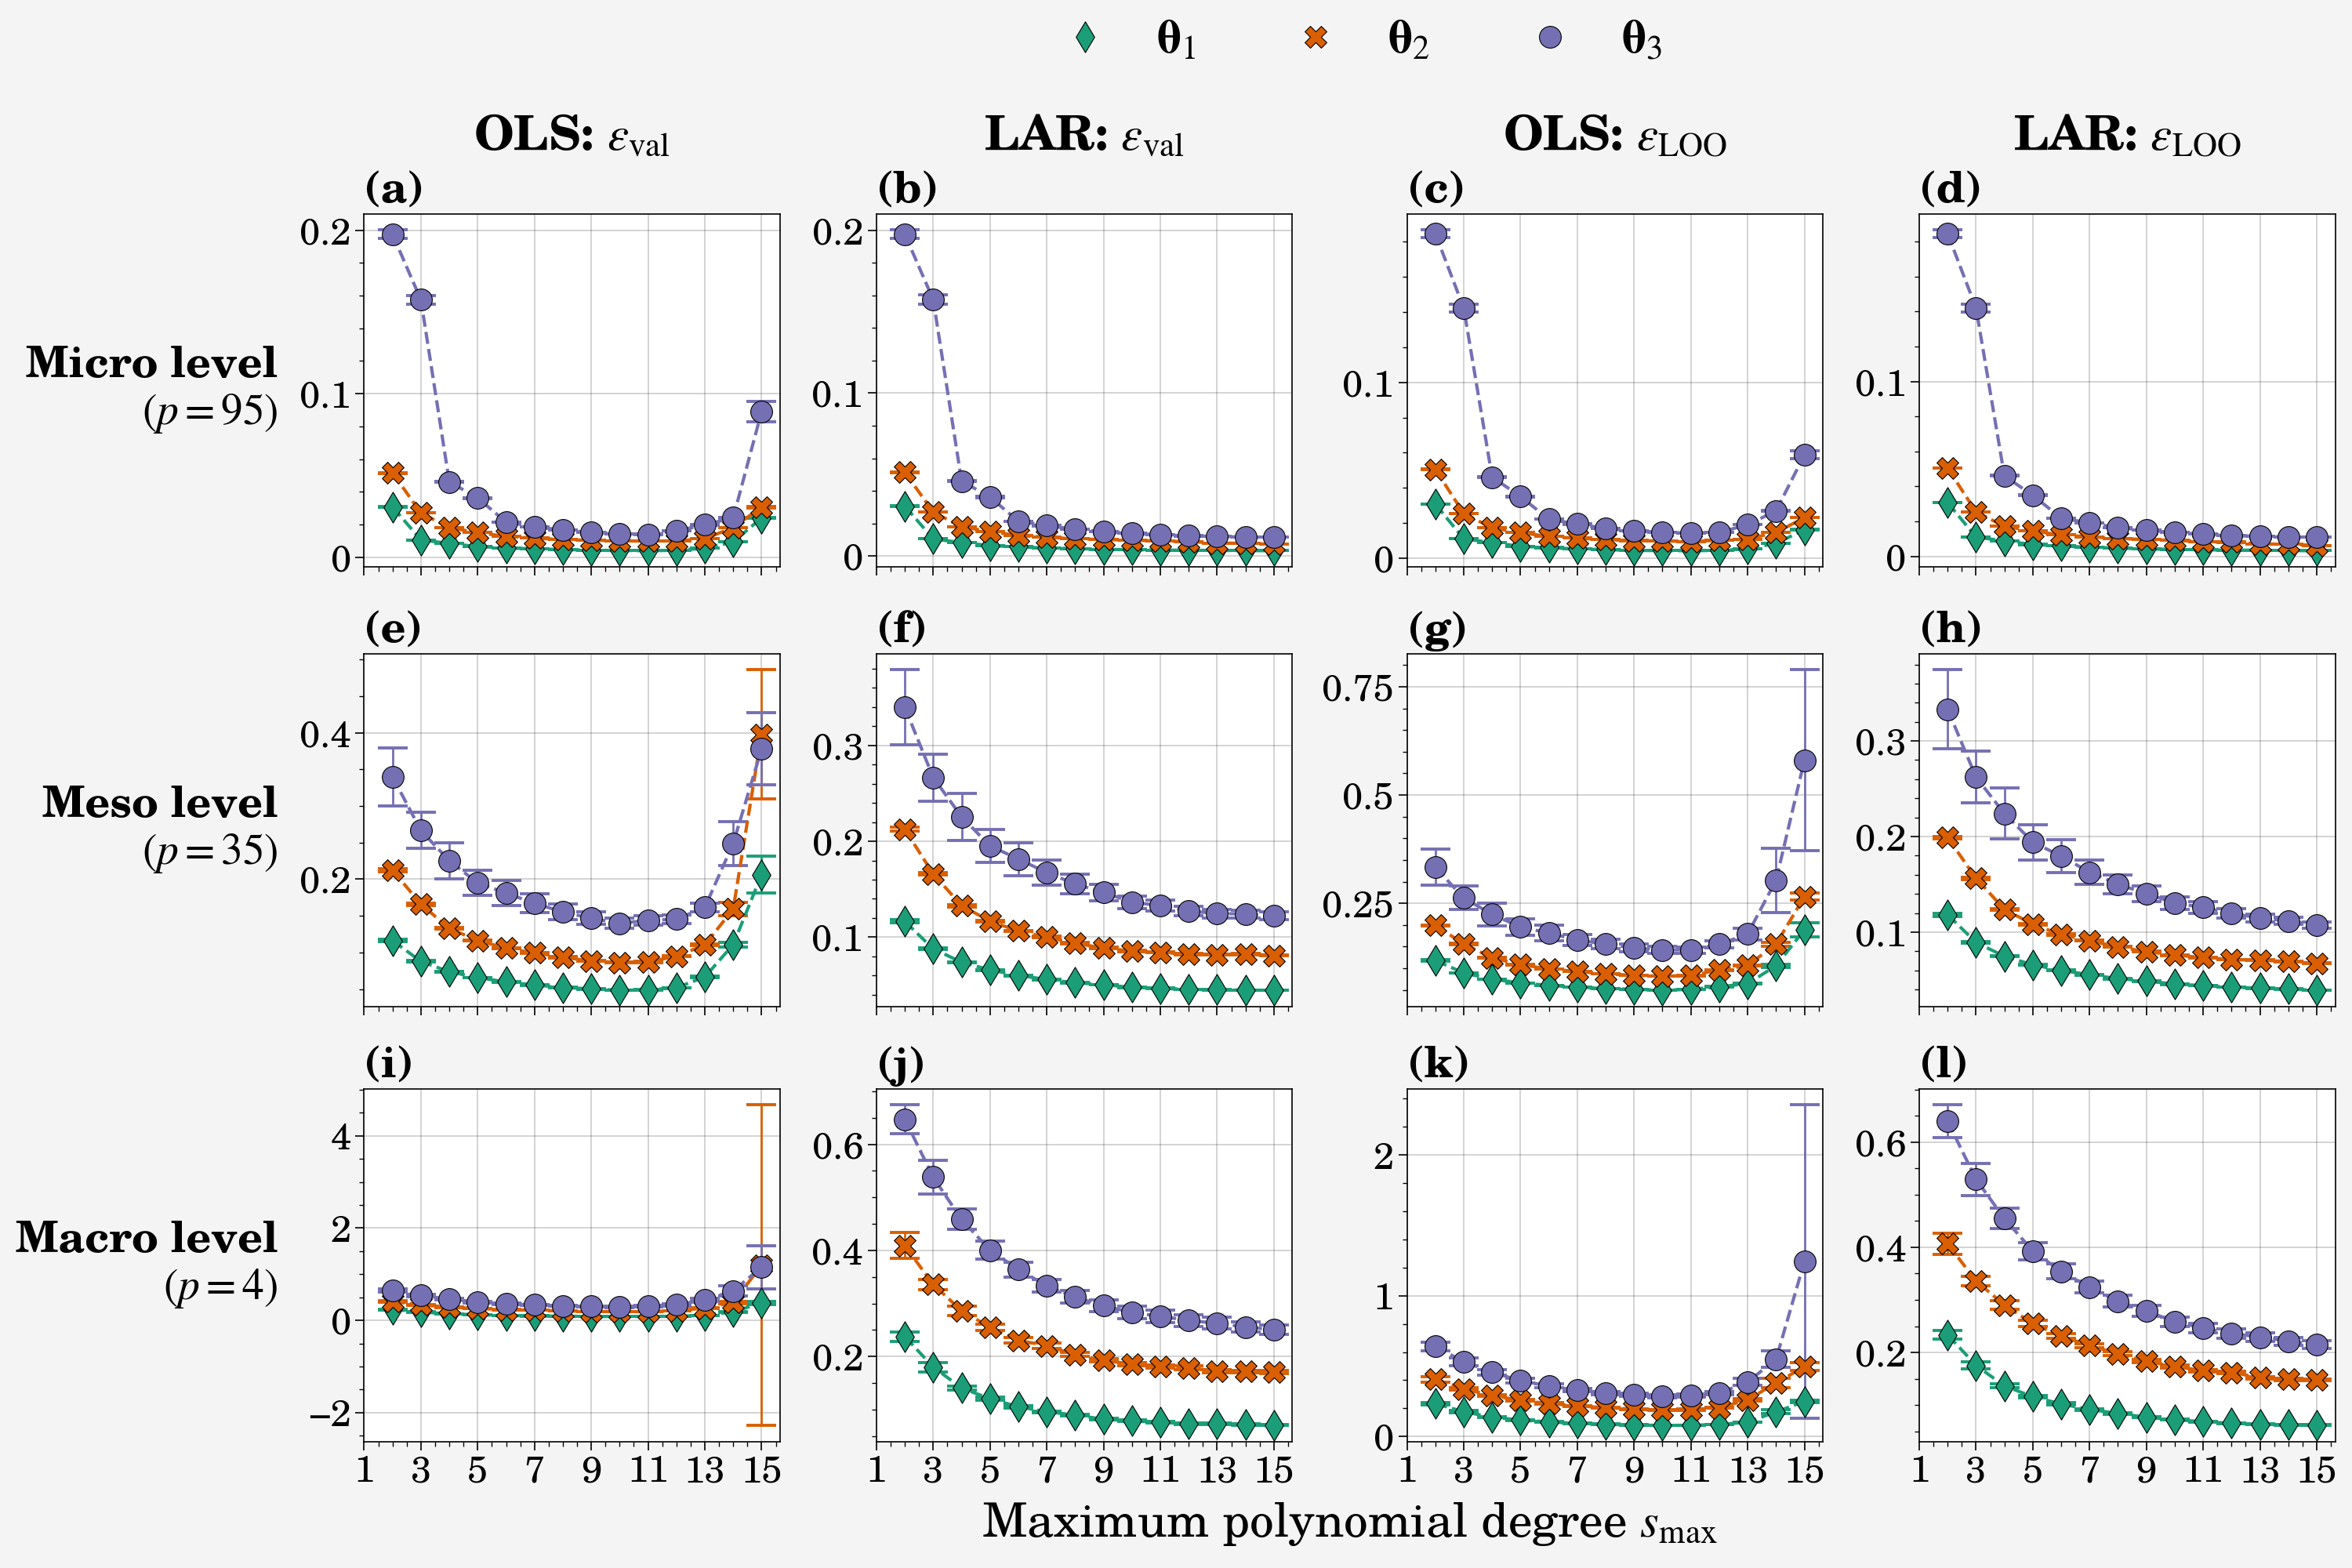

In [40]:
plot_GSA_errors(errors = OLS_LAR_errors_wo_MAE, 
                n_plot_cols = 4,
                suptitle = None, 
                figsize = (15, 10),
                legend_n_cols = 3, 
                toplabels = (r"OLS: $\epsilon_{\mathrm{val}}$", 
                             r"LAR: $\epsilon_{\mathrm{val}}$",
                             r"OLS: $\epsilon_{\mathrm{LOO}}$",
                             r"LAR: $\epsilon_{\mathrm{LOO}}$",), 
                leftlabels=["Micro level\n"+r"$(p=95)$", "Meso level\n"+r"$(p=35)$",
                            "Macro level\n"+r"$(p=4)$"], 
                title = "PT3_OLS_LAR_errors_wo_MAE.pdf", 
                top=True)

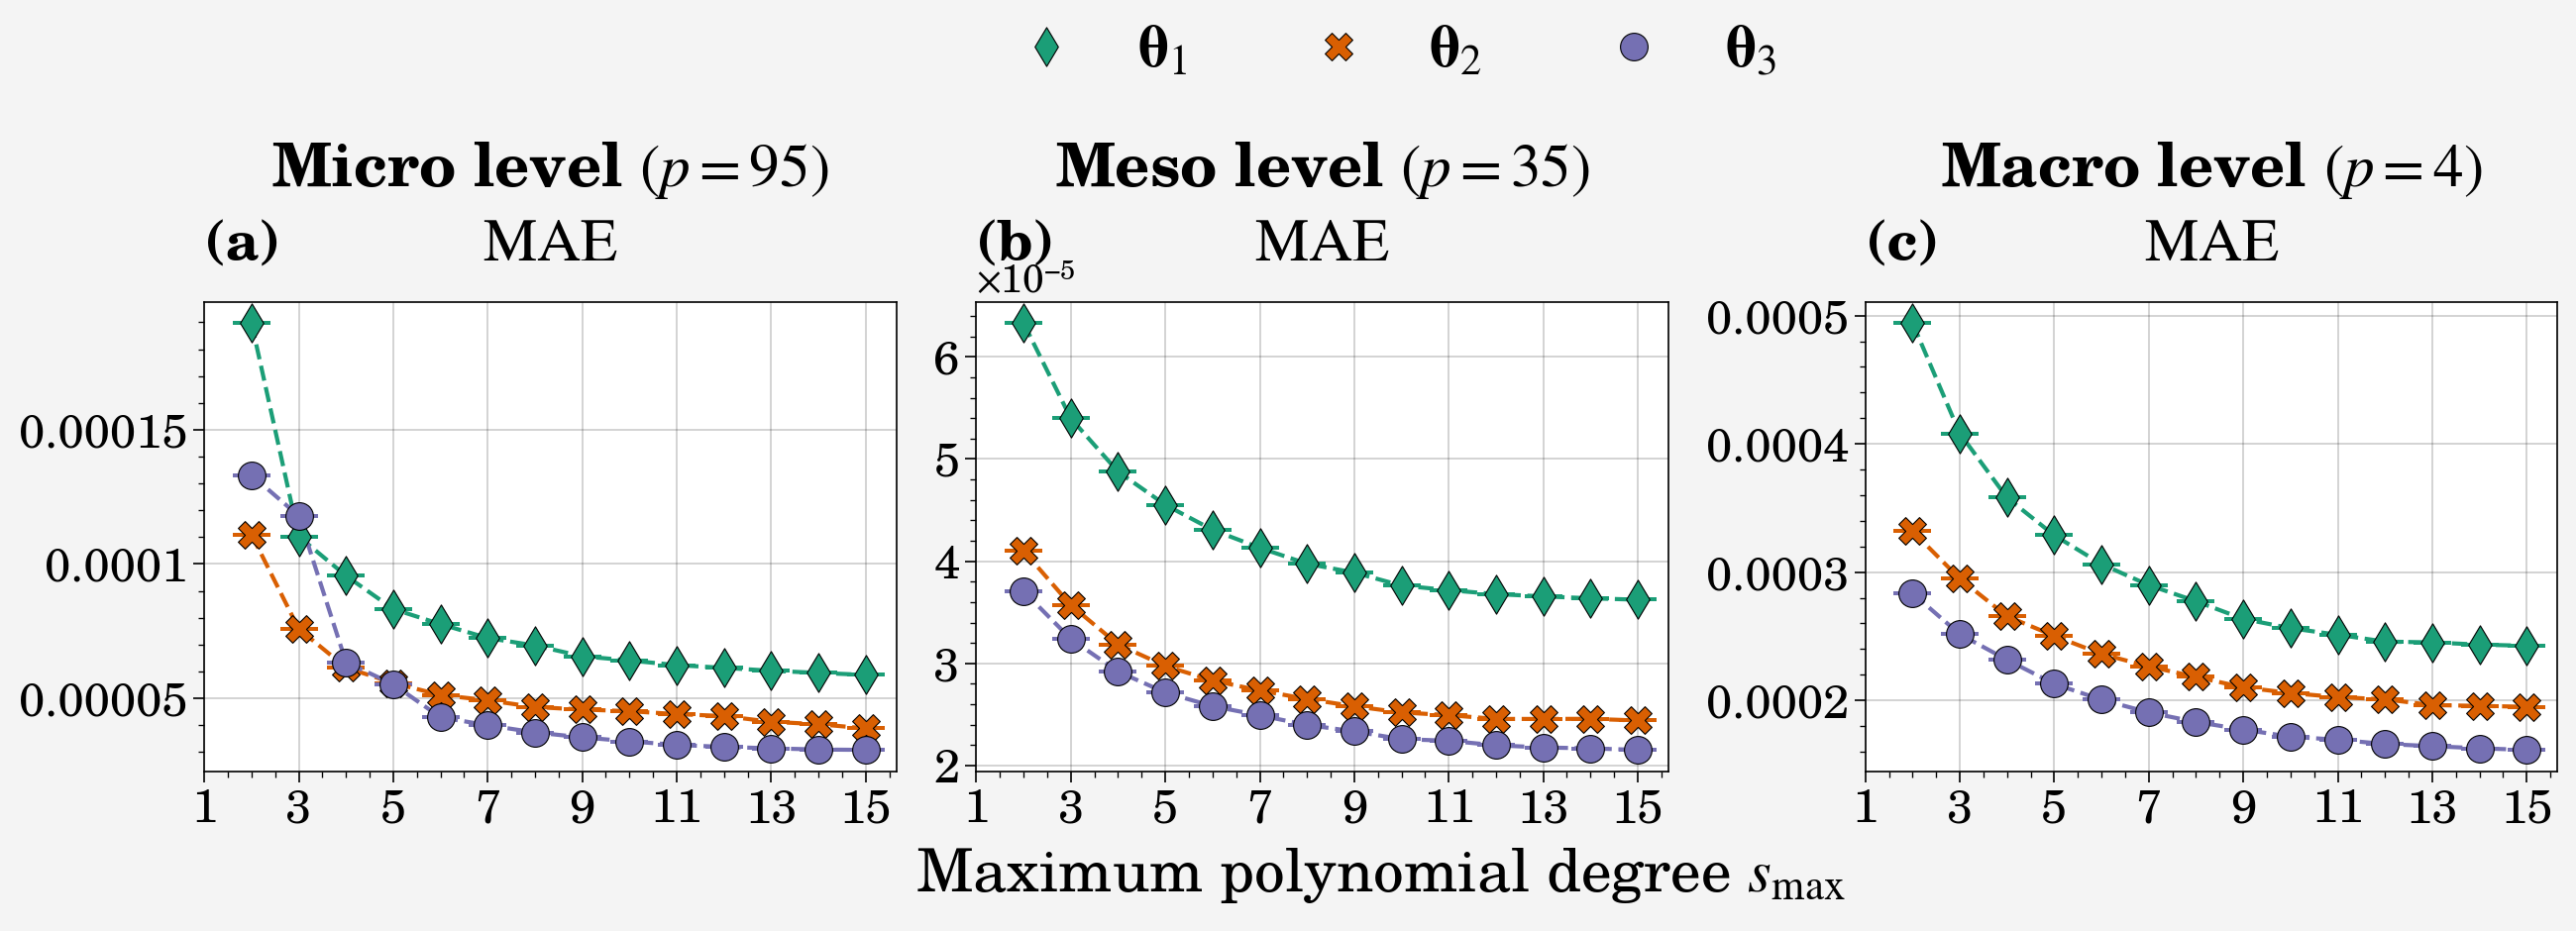

In [41]:
plot_MAE(errors = errors_MAE, 
        n_plot_cols = 3,
        suptitle = None, 
        figsize = (13, 4.7),
        legend_n_cols = 3, 
        toplabels = ("Micro level "+r"$(p=95)$", 
                     "Meso level "+r"$(p=35)$",
                    "Macro level "+r"$(p=4)$"),
        title = "PT3_LAR_MAE.pdf", 
        top=True)